## 📖 Análisis de Interpretabilidad del Modelo
**Analiza la explicabilidad y comprensibilidad del modelo Decision Tree para stakeholders no técnicos.**

In [ ]:
# ANÁLISIS DE INTERPRETABILIDAD DEL MODELO
print("=" * 80)
print("                    ANÁLISIS DE INTERPRETABILIDAD")
print("=" * 80)

# 1. MÉTRICAS DE INTERPRETABILIDAD
print("\n🔍 MÉTRICAS DE INTERPRETABILIDAD")

# Profundidad del árbol
depth = best_dt.get_depth()
n_nodes = best_dt.tree_.node_count
n_leaves = best_dt.get_n_leaves()

print(f"Profundidad máxima del árbol: {depth}")
print(f"Número total de nodos: {n_nodes}")
print(f"Número de hojas (decisiones finales): {n_leaves}")

# Clasificar interpretabilidad
if depth <= 3:
    interpretability_level = "🏆 ALTAMENTE INTERPRETABLE"
    interpretability_desc = "Fácil de explicar a cualquier audiencia"
elif depth <= 5:
    interpretability_level = "✅ MUY INTERPRETABLE"
    interpretability_desc = "Explicable con diagramas simples"
elif depth <= 8:
    interpretability_level = "📊 MODERADAMENTE INTERPRETABLE"
    interpretability_desc = "Requiere herramientas de visualización"
else:
    interpretability_level = "⚠️ COMPLEJIDAD ALTA"
    interpretability_desc = "Difícil de interpretar manualmente"

print(f"\nNivel de interpretabilidad: {interpretability_level}")
print(f"Descripción: {interpretability_desc}")

# 2. ANÁLISIS DE REGLAS DE DECISIÓN
print(f"\n📋 ANÁLISIS DE REGLAS DE DECISIÓN")

# Extraer algunas reglas clave del árbol
from sklearn.tree import export_text

# Obtener reglas del árbol (limitadas para legibilidad)
if depth <= 6:  # Solo mostrar si no es muy complejo
    tree_rules = export_text(best_dt, feature_names=list(X.columns), max_depth=3)
    print("\n--- REGLAS PRINCIPALES DEL ÁRBOL (Primeros 3 niveles) ---")
    print(tree_rules[:2000] + "..." if len(tree_rules) > 2000 else tree_rules)
else:
    print("⚠️ Árbol demasiado complejo para mostrar reglas detalladas")
    print("Se recomienda usar herramientas de visualización específicas")

# 3. ANÁLISIS DE VARIABLES CRÍTICAS PARA INTERPRETACIÓN
print(f"\n🎯 VARIABLES CRÍTICAS PARA INTERPRETACIÓN")

# Top variables para explicar el modelo
top_vars_interpretation = importances.head(8)  # Top 8 para interpretación

print("Variables más importantes para explicar predicciones:")
for i, (var, importance) in enumerate(top_vars_interpretation.items(), 1):
    print(f"{i}. {var}: {importance:.3f} ({importance*100:.1f}%)")

# 4. SCORE DE INTERPRETABILIDAD
print(f"\n📈 SCORE DE INTERPRETABILIDAD")

# Factores de interpretabilidad
interpretability_factors = {
    'depth_score': max(0, (10 - depth) / 10),  # Mejor si menos profundo
    'simplicity_score': max(0, (50 - n_leaves) / 50),  # Mejor si menos hojas
    'feature_concentration': min(1, top10_sum),  # Mejor si pocas variables explican mucho
    'tree_balance': min(1, 1 - (gini_importance / 0.7))  # Mejor si no muy desbalanceado
}

interpretability_score = np.mean(list(interpretability_factors.values()))

print(f"Score de profundidad: {interpretability_factors['depth_score']:.3f}")
print(f"Score de simplicidad: {interpretability_factors['simplicity_score']:.3f}")
print(f"Score de concentración: {interpretability_factors['feature_concentration']:.3f}")
print(f"Score de balance: {interpretability_factors['tree_balance']:.3f}")
print(f"\nSCORE GLOBAL DE INTERPRETABILIDAD: {interpretability_score:.3f}")

if interpretability_score > 0.8:
    interp_status = "🏆 EXCELENTE INTERPRETABILIDAD"
elif interpretability_score > 0.6:
    interp_status = "✅ BUENA INTERPRETABILIDAD"
elif interpretability_score > 0.4:
    interp_status = "⚠️ INTERPRETABILIDAD MODERADA"
else:
    interp_status = "❌ BAJA INTERPRETABILIDAD"

print(f"Clasificación: {interp_status}")

# 5. RECOMENDACIONES PARA INTERPRETACIÓN
print(f"\n💡 RECOMENDACIONES PARA INTERPRETACIÓN")

if depth <= 5:
    print("✅ Crear diagrama del árbol completo")
    print("✅ Explicar reglas de decisión paso a paso")
elif depth <= 8:
    print("📊 Usar visualizaciones interactivas")
    print("📊 Enfocar en top branches más importantes")
else:
    print("⚠️ Usar feature importance para explicación general")
    print("⚠️ Crear ejemplos específicos de predicción")

# Para stakeholders no técnicos
print(f"\n👥 PARA STAKEHOLDERS NO TÉCNICOS:")
print(f"• El modelo toma decisiones basado en {len(top_vars_interpretation)} variables principales")
print(f"• Las 3 variables más importantes son:")
for i, var in enumerate(list(top_vars_interpretation.index[:3]), 1):
    print(f"  {i}. {var}")
print(f"• Nivel de complejidad: {interpretability_level.split(' ')[1].lower()}")
print(f"• Confianza en explicaciones: {interpretability_score:.0%}")

print("=" * 80)

## 🛡️ Análisis de Robustez del Modelo
**Evalúa la estabilidad del modelo ante pequeñas perturbaciones en los datos y hiperparámetros.**

# Decision Tree Regressor - Análisis de Consumo Energético

Este notebook implementa un modelo de **Decision Tree Regression** para predecir el consumo energético basado en características del edificio, ocupantes, electrodomésticos y condiciones ambientales.

## Configuración de rutas y entorno
Define la raíz del proyecto, rutas estándar y crea carpetas necesarias para figuras y modelos, asegurando portabilidad del notebook en diferentes ubicaciones.

In [61]:
from pathlib import Path

PROJECT_MARKERS = {"data", "models", "notebook", "src"}
MAX_UP = 6

def find_project_root(start: Path) -> Path:
    cur = start.resolve()
    for _ in range(MAX_UP):
        names = {p.name for p in cur.iterdir() if p.is_dir()}
        if PROJECT_MARKERS.issubset(names) or "data" in names:
            return cur
        if cur.parent == cur:
            break
        cur = cur.parent
    raise RuntimeError("No pude detectar la raíz del proyecto.")

ROOT = find_project_root(Path.cwd())
DATA_DIR = (ROOT / "data").resolve()
PROC_DIR = (DATA_DIR / "processed").resolve()
FIG_DIR  = (DATA_DIR / "figures" / "decision_tree_regression").resolve()
MODEL_DIR = (ROOT / "models").resolve()

FIG_DIR.mkdir(parents=True, exist_ok=True)
MODEL_DIR.mkdir(parents=True, exist_ok=True)

print("ROOT:", ROOT)
print("PROC_DIR:", PROC_DIR)
print("FIG_DIR:", FIG_DIR)
print("MODEL_DIR:", MODEL_DIR)


ROOT: /Users/cristian/Desktop/Project-Regression-Equipo-2 copia
PROC_DIR: /Users/cristian/Desktop/Project-Regression-Equipo-2 copia/data/processed
FIG_DIR: /Users/cristian/Desktop/Project-Regression-Equipo-2 copia/data/figures/decision_tree_regression
MODEL_DIR: /Users/cristian/Desktop/Project-Regression-Equipo-2 copia/models


## Imports y utilidades para Decision Tree Regression

Importamos las librerías necesarias para implementar Decision Trees:
- **Scikit-learn**: `DecisionTreeRegressor` y herramientas de evaluación
- **Visualización**: Matplotlib, Seaborn para gráficos del árbol y métricas
- **Métricas**: MSE, MAE, R² para evaluar el modelo de regresión
- **Preprocesamiento**: Herramientas para división de datos y validación
Carga librerías necesarias y define un helper para calcular métricas de regresión y estandarizar la salida.

In [62]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Scikit-learn imports para Decision Trees
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, KFold
from sklearn.tree import DecisionTreeRegressor, plot_tree, export_text
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Para guardar modelos y visualización del árbol
from joblib import dump, load
import warnings
warnings.filterwarnings('ignore')

# Configuración de visualización
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)

SEED = 42
np.random.seed(SEED)

def regression_report(y_true, y_pred, label=""):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    print(f"{label} -> MAE: {mae:.3f} | RMSE: {rmse:.3f} | R²: {r2:.4f}")
    return {"MAE": mae, "RMSE": rmse, "R2": r2}


## Localización y carga de los datasets
Busca automáticamente CSVs en data/processed/ para train y test. Carga ambos DataFrames para comparación y entrenamiento.

In [63]:
# Configurar datasets de entrenamiento y test
TRAIN_FILE = "energy_data_processed.csv"
TEST_FILE = "energy_data_test_processed.csv"

# Buscar archivos de entrenamiento
train_path = PROC_DIR / TRAIN_FILE
test_path = PROC_DIR / TEST_FILE

if not train_path.exists():
    # Buscar cualquier CSV de entrenamiento
    candidates = sorted(PROC_DIR.glob("*processed.csv"))
    if candidates:
        train_path = candidates[0]
    else:
        raise FileNotFoundError("No encontré CSVs de entrenamiento en data/processed/.")

if not test_path.exists():
    print(f"⚠️ Archivo de test {TEST_FILE} no encontrado. Usando solo datos de entrenamiento.")
    test_available = False
else:
    test_available = True

print("=== Configuración de Datasets ===")
print(f"TRAIN PATH: {train_path}")
if test_available:
    print(f"TEST PATH:  {test_path}")
    print("✅ Ambos datasets disponibles para comparación")
else:
    print("📝 Solo dataset de entrenamiento disponible")

# Cargar dataset de entrenamiento
df_train = pd.read_csv(train_path)
print(f"\n=== Dataset de Entrenamiento ===")
print(f"Shape: {df_train.shape}")
print("Columnas:", list(df_train.columns))
display(df_train.head())

# Cargar dataset de test si está disponible
if test_available:
    df_test_external = pd.read_csv(test_path)
    print(f"\n=== Dataset de Test Externo ===")
    print(f"Shape: {df_test_external.shape}")
    print("Columnas:", list(df_test_external.columns))
    display(df_test_external.head())

    # Comparar estructuras
    train_cols = set(df_train.columns)
    test_cols = set(df_test_external.columns)

    if train_cols == test_cols:
        print("✅ Ambos datasets tienen las mismas columnas")
    else:
        missing_in_test = train_cols - test_cols
        extra_in_test = test_cols - train_cols
        if missing_in_test:
            print(f"⚠️ Columnas faltantes en test: {missing_in_test}")
        if extra_in_test:
            print(f"⚠️ Columnas extra en test: {extra_in_test}")

# Usar el dataset de entrenamiento para el análisis principal
df = df_train.copy()
print(f"\n=== Dataset Principal (Entrenamiento) ===")
print(f"Usando: {train_path.name}")
print(f"Shape: {df.shape}")

=== Configuración de Datasets ===
TRAIN PATH: /Users/cristian/Desktop/Project-Regression-Equipo-2 copia/data/processed/energy_data_processed.csv
TEST PATH:  /Users/cristian/Desktop/Project-Regression-Equipo-2 copia/data/processed/energy_data_test_processed.csv
✅ Ambos datasets disponibles para comparación

=== Dataset de Entrenamiento ===
Shape: (1000, 10)
Columnas: ['Square Footage', 'Number of Occupants', 'Appliances Used', 'Average Temperature', 'Energy Consumption', 'Building Type_Commercial', 'Building Type_Industrial', 'Building Type_Residential', 'Day of Week_Weekday', 'Day of Week_Weekend']


,Square Footage,Number of Occupants,Appliances Used,Average Temperature,Energy Consumption,Building Type_Commercial,Building Type_Industrial,Building Type_Residential,Day of Week_Weekday,Day of Week_Weekend
0,7063,76,10,29.84,2713.95,0,0,1,1,0
1,44372,66,45,16.72,5744.99,1,0,0,1,0
2,19255,37,17,14.30,4101.24,0,1,0,0,1
3,13265,14,41,32.82,3009.14,0,0,1,1,0
4,13375,26,18,11.92,3279.17,1,0,0,1,0



=== Dataset de Test Externo ===
Shape: (100, 10)
Columnas: ['Square Footage', 'Number of Occupants', 'Appliances Used', 'Average Temperature', 'Energy Consumption', 'Building Type_Commercial', 'Building Type_Industrial', 'Building Type_Residential', 'Day of Week_Weekday', 'Day of Week_Weekend']


,Square Footage,Number of Occupants,Appliances Used,Average Temperature,Energy Consumption,Building Type_Commercial,Building Type_Industrial,Building Type_Residential,Day of Week_Weekday,Day of Week_Weekend
0,24563,15,4,28.52,2865.57,0,0,1,1,0
1,27583,56,23,23.07,4283.80,1,0,0,0,1
2,45313,4,44,33.56,5067.83,1,0,0,1,0
3,41625,84,17,27.39,4624.30,0,0,1,0,1
4,36720,58,47,17.08,4820.59,0,0,1,1,0


✅ Ambos datasets tienen las mismas columnas

=== Dataset Principal (Entrenamiento) ===
Usando: energy_data_processed.csv
Shape: (1000, 10)


## Definición de variables objetivo y features
Determina la columna objetivo y prepara features para entrenamiento. Si hay dataset de test externo, también lo prepara para comparación posterior.

In [64]:
# Detectar columna objetivo (target)
preferred_targets = ["Energy Consumption", "energy_consumption", "energy_kwh", "consumption"]
target = None
for t in preferred_targets:
    if t in df.columns:
        target = t
        break
if target is None:
    num_cols = df.select_dtypes(include=["number"]).columns
    energy_like = [c for c in num_cols if "energy" in c.lower()]
    target = energy_like[0] if energy_like else df[num_cols].var().sort_values(ascending=False).index[0]

# Definir features (excluir target y columnas no deseadas)
drop_like = set()
features = [c for c in df.columns if c != target and c not in drop_like]

# Preparar datos de entrenamiento
X = df[features].copy()
y = df[target].copy()

# Convertir booleanos a enteros y manejar nulos
for c in X.select_dtypes(include=["bool"]).columns:
    X[c] = X[c].astype(int)
X = X.fillna(X.median(numeric_only=True))
y = y.fillna(y.median())

print("=== Configuración de Entrenamiento ===")
print(f"Target: {target}")
print(f"Nº features: {len(features)}")
print(f"X shape: {X.shape} | y shape: {y.shape}")

# Preparar dataset de test externo si está disponible
if test_available:
    print(f"\n=== Preparación Dataset de Test Externo ===")

    # Verificar que tiene el target
    if target not in df_test_external.columns:
        print(f"⚠️ Target '{target}' no encontrado en dataset de test")
        print(f"Columnas disponibles: {list(df_test_external.columns)}")
        test_available = False
    else:
        # Preparar features de test (mismo orden que entrenamiento)
        missing_features = [f for f in features if f not in df_test_external.columns]
        if missing_features:
            print(f"⚠️ Features faltantes en test: {missing_features}")
            # Usar solo features disponibles en ambos datasets
            common_features = [f for f in features if f in df_test_external.columns]
            X = X[common_features]
            features = common_features
            print(f"Usando {len(common_features)} features comunes")

        X_test_external = df_test_external[features].copy()
        y_test_external = df_test_external[target].copy()

        # Mismo preprocesamiento que entrenamiento
        for c in X_test_external.select_dtypes(include=["bool"]).columns:
            X_test_external[c] = X_test_external[c].astype(int)
        X_test_external = X_test_external.fillna(X_test_external.median(numeric_only=True))
        y_test_external = y_test_external.fillna(y_test_external.median())

        print(f"X_test_external shape: {X_test_external.shape} | y_test_external shape: {y_test_external.shape}")
        print("✅ Dataset de test externo preparado para comparación")

print(f"\n=== Resumen Final ===")
print(f"Entrenamiento: {X.shape[0]} muestras, {X.shape[1]} features")
if test_available:
    print(f"Test externo: {X_test_external.shape[0]} muestras, {X_test_external.shape[1]} features")
    print("📊 Listo para entrenar y comparar con dataset externo")
else:
    print("📊 Listo para entrenar con validación cruzada interna")

=== Configuración de Entrenamiento ===
Target: Energy Consumption
Nº features: 9
X shape: (1000, 9) | y shape: (1000,)

=== Preparación Dataset de Test Externo ===
X_test_external shape: (100, 9) | y_test_external shape: (100,)
✅ Dataset de test externo preparado para comparación

=== Resumen Final ===
Entrenamiento: 1000 muestras, 9 features
Test externo: 100 muestras, 9 features
📊 Listo para entrenar y comparar con dataset externo


## Análisis Estadístico Descriptivo Comparativo
**Análisis riguroso de las distribuciones de ambos datasets para validar homogeneidad y detectar drift de datos.**

=== ANÁLISIS ESTADÍSTICO COMPARATIVO RIGUROSO ===
Dataset Train: 1000 muestras
Dataset Test:  100 muestras

📊 ANÁLISIS DE VARIABLE OBJETIVO: 'Energy Consumption'

--- Estadísticas Descriptivas del Target ---


,Train,Test,Diferencia_Abs,Diferencia_Rel_%
count,1000.000,100.000,900.000,90.000
mean,4166.253,4187.578,21.326,0.512
std,933.313,832.560,100.753,10.795
min,1683.950,2351.970,668.020,39.670
25%,3509.482,3621.925,112.443,3.204
50%,4175.730,4249.390,73.660,1.764
75%,4863.850,4797.175,66.675,1.371
max,6530.600,6042.560,488.040,7.473



--- Test de Normalidad (Shapiro-Wilk) ---
Train p-value: 0.0002 (No Normal)
Test p-value:  0.2281 (Normal)

--- Test de Homogeneidad de Varianzas (Levene) ---
p-value: 0.0842
✅ Varianzas homogéneas (no hay diferencia significativa)

--- Test de Diferencia de Distribuciones (Mann-Whitney U (no paramétrico)) ---
p-value: 0.7282
✅ No hay diferencia significativa entre las distribuciones

--- Test Kolmogorov-Smirnov (distribuciones completas) ---
KS statistic: 0.0960, p-value: 0.3537
✅ Distribuciones estadísticamente similares

🔗 ANÁLISIS DE CORRELACIÓN ENTRE DATASETS
Datasets de diferente tamaño - usando correlación por cuartiles
Correlación entre cuartiles: 0.9988


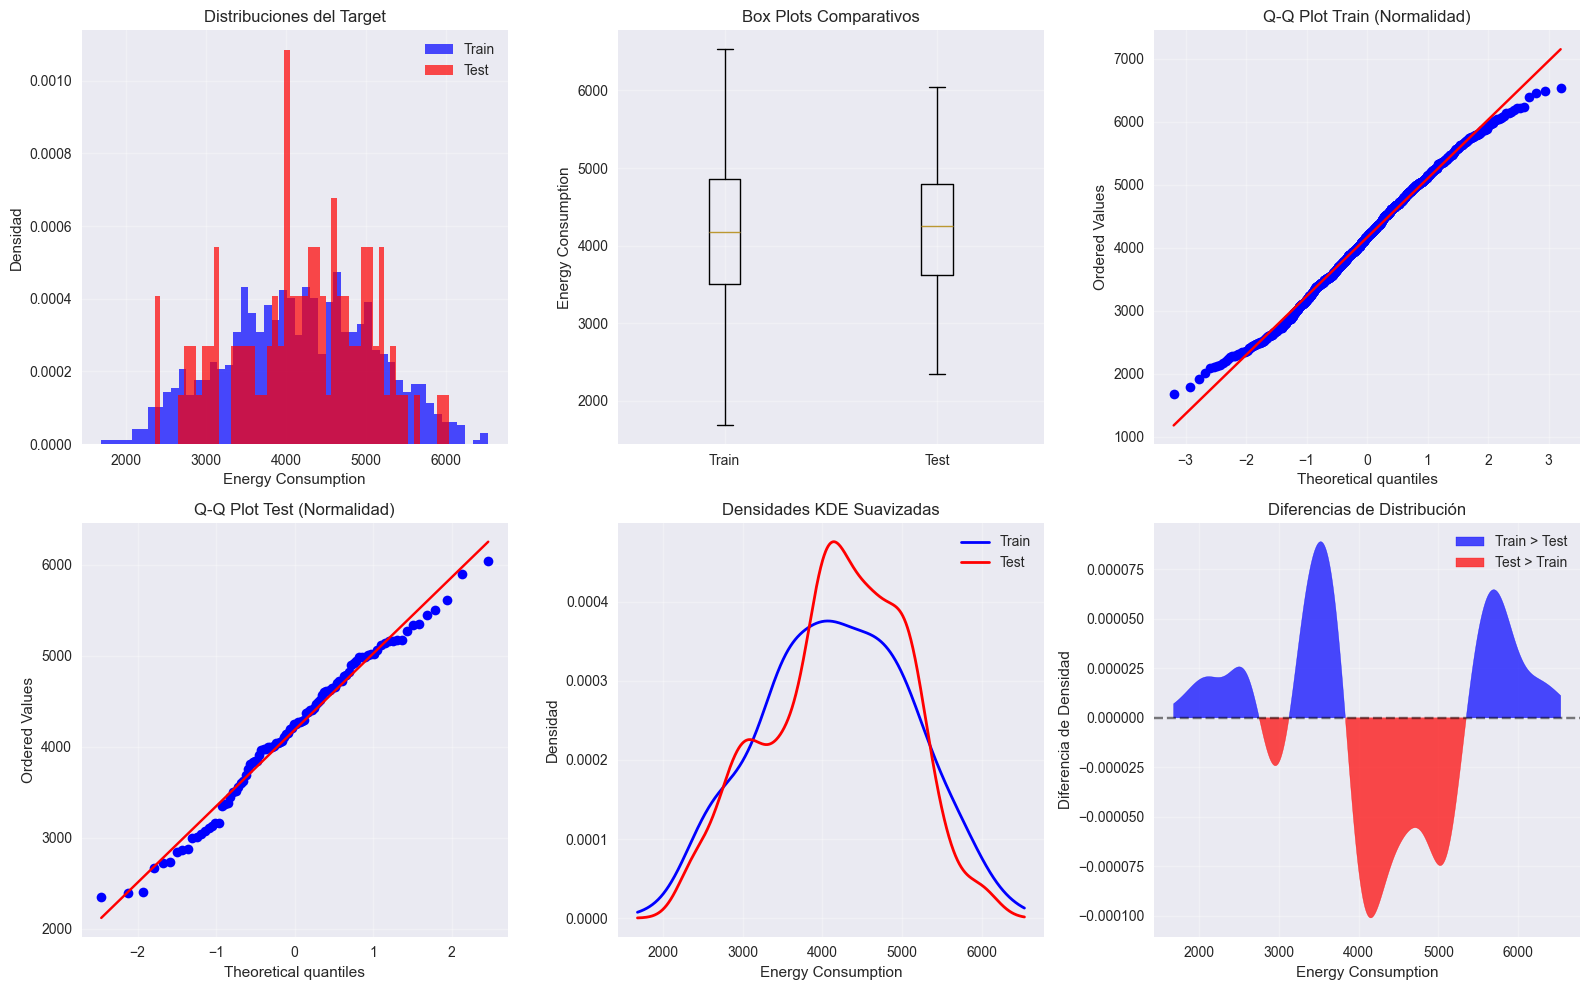


🎯 DIAGNÓSTICO FINAL DE HOMOGENEIDAD
Indicadores de drift: 0/3
Score de homogeneidad: 100.0%
🟢 DATASETS COMPLETAMENTE HOMOGÉNEOS
Validación cruzada será representativa del test externo


In [65]:
if test_available:
    from scipy import stats
    import scipy.stats as st

    print("=== ANÁLISIS ESTADÍSTICO COMPARATIVO RIGUROSO ===")
    print(f"Dataset Train: {df_train.shape[0]} muestras")
    print(f"Dataset Test:  {df_test_external.shape[0]} muestras")

    # 1. ANÁLISIS DE LA VARIABLE OBJETIVO
    print(f"\n📊 ANÁLISIS DE VARIABLE OBJETIVO: '{target}'")
    target_train = df_train[target]
    target_test = df_test_external[target]

    # Estadísticas descriptivas
    stats_comparison = pd.DataFrame({
        'Train': target_train.describe(),
        'Test': target_test.describe(),
        'Diferencia_Abs': abs(target_train.describe() - target_test.describe()),
        'Diferencia_Rel_%': (abs(target_train.describe() - target_test.describe()) / target_train.describe() * 100)
    })

    print("\n--- Estadísticas Descriptivas del Target ---")
    display(stats_comparison.round(3))

    # Test de normalidad
    _, p_train_norm = st.shapiro(target_train.sample(min(5000, len(target_train))))
    _, p_test_norm = st.shapiro(target_test.sample(min(5000, len(target_test))))

    print(f"\n--- Test de Normalidad (Shapiro-Wilk) ---")
    print(f"Train p-value: {p_train_norm:.4f} {'(Normal)' if p_train_norm > 0.05 else '(No Normal)'}")
    print(f"Test p-value:  {p_test_norm:.4f} {'(Normal)' if p_test_norm > 0.05 else '(No Normal)'}")

    # Test de homogeneidad de varianzas (Levene)
    _, p_levene = st.levene(target_train, target_test)
    print(f"\n--- Test de Homogeneidad de Varianzas (Levene) ---")
    print(f"p-value: {p_levene:.4f}")
    if p_levene > 0.05:
        print("✅ Varianzas homogéneas (no hay diferencia significativa)")
    else:
        print("⚠️ Varianzas heterogéneas (diferencia significativa)")

    # Test de diferencia de medias
    if p_train_norm > 0.05 and p_test_norm > 0.05:
        # Usar t-test si ambos son normales
        _, p_ttest = st.ttest_ind(target_train, target_test)
        test_usado = "t-test (paramétrico)"
    else:
        # Usar Mann-Whitney U si no son normales
        _, p_ttest = st.mannwhitneyu(target_train, target_test)
        test_usado = "Mann-Whitney U (no paramétrico)"

    print(f"\n--- Test de Diferencia de Distribuciones ({test_usado}) ---")
    print(f"p-value: {p_ttest:.4f}")
    if p_ttest > 0.05:
        print("✅ No hay diferencia significativa entre las distribuciones")
        drift_target = False
    else:
        print("⚠️ Diferencia significativa detectada (posible data drift)")
        drift_target = True

    # Kolmogorov-Smirnov test para comparar distribuciones completas
    ks_stat, p_ks = st.ks_2samp(target_train, target_test)
    print(f"\n--- Test Kolmogorov-Smirnov (distribuciones completas) ---")
    print(f"KS statistic: {ks_stat:.4f}, p-value: {p_ks:.4f}")
    if p_ks > 0.05:
        print("✅ Distribuciones estadísticamente similares")
    else:
        print("⚠️ Distribuciones significativamente diferentes")

    # 2. ANÁLISIS DE CORRELACIONES ENTRE DATASETS
    print(f"\n🔗 ANÁLISIS DE CORRELACIÓN ENTRE DATASETS")

    # Correlación entre targets
    if len(target_train) == len(target_test):
        corr_targets = np.corrcoef(target_train, target_test)[0,1]
        print(f"Correlación directa entre targets: {corr_targets:.4f}")
    else:
        print("Datasets de diferente tamaño - usando correlación por cuartiles")
        q_train = np.percentile(target_train, [25, 50, 75])
        q_test = np.percentile(target_test, [25, 50, 75])
        corr_quartiles = np.corrcoef(q_train, q_test)[0,1]
        print(f"Correlación entre cuartiles: {corr_quartiles:.4f}")

    # 3. VISUALIZACIÓN COMPARATIVA DE DISTRIBUCIONES
    plt.figure(figsize=(16, 10))

    # Histogramas comparativos
    plt.subplot(2, 3, 1)
    plt.hist(target_train, bins=50, alpha=0.7, label='Train', color='blue', density=True)
    plt.hist(target_test, bins=50, alpha=0.7, label='Test', color='red', density=True)
    plt.xlabel(target)
    plt.ylabel('Densidad')
    plt.title('Distribuciones del Target')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Box plots comparativos
    plt.subplot(2, 3, 2)
    plt.boxplot([target_train, target_test], labels=['Train', 'Test'])
    plt.ylabel(target)
    plt.title('Box Plots Comparativos')
    plt.grid(True, alpha=0.3)

    # Q-Q plot para normalidad
    plt.subplot(2, 3, 3)
    st.probplot(target_train, dist="norm", plot=plt)
    plt.title('Q-Q Plot Train (Normalidad)')
    plt.grid(True, alpha=0.3)

    plt.subplot(2, 3, 4)
    st.probplot(target_test, dist="norm", plot=plt)
    plt.title('Q-Q Plot Test (Normalidad)')
    plt.grid(True, alpha=0.3)

    # Densidades suavizadas
    plt.subplot(2, 3, 5)
    from sklearn.neighbors import KernelDensity
    kde_train = KernelDensity(bandwidth=np.std(target_train)/4)
    kde_test = KernelDensity(bandwidth=np.std(target_test)/4)

    x_range = np.linspace(min(target_train.min(), target_test.min()),
                         max(target_train.max(), target_test.max()), 1000)

    kde_train.fit(target_train.values.reshape(-1, 1))
    kde_test.fit(target_test.values.reshape(-1, 1))

    density_train = np.exp(kde_train.score_samples(x_range.reshape(-1, 1)))
    density_test = np.exp(kde_test.score_samples(x_range.reshape(-1, 1)))

    plt.plot(x_range, density_train, label='Train', color='blue', linewidth=2)
    plt.plot(x_range, density_test, label='Test', color='red', linewidth=2)
    plt.xlabel(target)
    plt.ylabel('Densidad')
    plt.title('Densidades KDE Suavizadas')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Diferencia de densidades
    plt.subplot(2, 3, 6)
    density_diff = density_train - density_test
    plt.fill_between(x_range, 0, density_diff, where=(density_diff >= 0),
                     alpha=0.7, color='blue', label='Train > Test')
    plt.fill_between(x_range, 0, density_diff, where=(density_diff < 0),
                     alpha=0.7, color='red', label='Test > Train')
    plt.xlabel(target)
    plt.ylabel('Diferencia de Densidad')
    plt.title('Diferencias de Distribución')
    plt.axhline(y=0, color='black', linestyle='--', alpha=0.5)
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig(FIG_DIR / "distribuciones_comparativas_target.png", dpi=150, bbox_inches='tight')
    plt.show()

    # 4. DIAGNÓSTICO FINAL DE HOMOGENEIDAD
    print(f"\n🎯 DIAGNÓSTICO FINAL DE HOMOGENEIDAD")
    drift_indicators = [drift_target, p_levene < 0.05, p_ks < 0.01]  # Criterios más estrictos
    drift_score = sum(drift_indicators) / len(drift_indicators)

    print(f"Indicadores de drift: {sum(drift_indicators)}/{len(drift_indicators)}")
    print(f"Score de homogeneidad: {(1-drift_score)*100:.1f}%")

    if drift_score == 0:
        print("🟢 DATASETS COMPLETAMENTE HOMOGÉNEOS")
        print("Validación cruzada será representativa del test externo")
    elif drift_score <= 0.33:
        print("🟡 DATASETS MODERADAMENTE HOMOGÉNEOS")
        print("Pequeñas diferencias detectadas - validación confiable")
    else:
        print("🔴 DATA DRIFT SIGNIFICATIVO DETECTADO")
        print("Validación cruzada puede no ser representativa del test externo")

else:
    print("=== Sin Dataset de Test Externo Disponible ===")
    print("Análisis estadístico comparativo requiere ambos datasets")
    print("Continuando con análisis descriptivo del dataset de entrenamiento")

    # Análisis descriptivo básico del entrenamiento
    print(f"\n📊 ANÁLISIS DESCRIPTIVO - DATASET DE ENTRENAMIENTO")
    print(f"Target: {target}")
    target_stats = df_train[target].describe()
    print(f"\nEstadísticas del Target:")
    display(target_stats)

    # Test de normalidad
    _, p_norm = st.shapiro(df_train[target].sample(min(5000, len(df_train))))
    print(f"\nTest de Normalidad (Shapiro-Wilk): p = {p_norm:.4f}")
    if p_norm > 0.05:
        print("✅ Target sigue distribución aproximadamente normal")
    else:
        print("⚠️ Target no sigue distribución normal")

## Partición en entrenamiento y prueba
Separa los datos en conjuntos de entrenamiento y prueba para evaluación honesta del desempeño.

In [66]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=SEED
)
X_train.shape, X_test.shape

((800, 9), (200, 9))

## Modelo baseline (árbol sin tuning)
Entrena un árbol simple para establecer una línea base de desempeño y detectar overfitting evidente.

In [67]:
dt_base = DecisionTreeRegressor(
    random_state=SEED,
    max_depth=10,
    min_samples_split=20,
    min_samples_leaf=10
)
dt_base.fit(X_train, y_train)

pred_train_base = dt_base.predict(X_train)
pred_test_base = dt_base.predict(X_test)

print("=== Baseline con regularización ===")
metrics_train_base = regression_report(y_train, pred_train_base, "Train")
metrics_test_base = regression_report(y_test, pred_test_base, "Test")

=== Baseline con regularización ===
Train -> MAE: 178.781 | RMSE: 219.648 | R²: 0.9453
Test -> MAE: 222.237 | RMSE: 272.320 | R²: 0.9089


## Ajuste de hiperparámetros con validación cruzada
Explora hiperparámetros críticos del árbol con GridSearchCV utilizando K-Fold para mejorar generalización.

In [68]:
# Grid más conservador para reducir overfitting
param_grid = {
    "max_depth": [3, 4, 5, 6],            # Expandido para mejor exploración
    "min_samples_leaf": [25, 30, 40, 50], # Más opciones
    "min_samples_split": [40, 50, 60, 80], # Más restrictivo
    "ccp_alpha": [0.01, 0.02, 0.03, 0.05]  # Más opciones de pruning
}

# Configuración de validación cruzada más robusta
from sklearn.model_selection import StratifiedKFold, RepeatedKFold
cv = RepeatedKFold(n_splits=5, n_repeats=3, random_state=SEED)  # Más robusto

# Configuración del GridSearchCV con múltiples métricas
scoring = {
    'rmse': 'neg_root_mean_squared_error',
    'mae': 'neg_mean_absolute_error',
    'r2': 'r2'
}

dt = DecisionTreeRegressor(random_state=SEED)

grid = GridSearchCV(
    estimator=dt,
    param_grid=param_grid,
    scoring=scoring,
    refit='rmse',  # Optimizar por RMSE
    cv=cv,
    n_jobs=-1,
    verbose=1,
    return_train_score=True
)

total_combinations = len(param_grid['max_depth']) * len(param_grid['min_samples_leaf']) * \
                    len(param_grid['min_samples_split']) * len(param_grid['ccp_alpha'])
total_fits = total_combinations * cv.get_n_splits() * cv.n_repeats

print("=== OPTIMIZACIÓN DE HIPERPARÁMETROS RIGUROSA ===")
print(f"Combinaciones de parámetros: {total_combinations}")
print(f"Total de fits (con CV repetida): {total_fits}")
print("Esto puede tardar varios minutos...")

grid.fit(X_train, y_train)

print("\n=== RESULTADOS DE LA OPTIMIZACIÓN ===")
print("Mejores parámetros:", grid.best_params_)
print("Mejor score CV (RMSE):", f"{-grid.best_score_:.3f}")

# Análisis detallado de la validación cruzada
cv_results_df = pd.DataFrame(grid.cv_results_)
print(f"\n=== ANÁLISIS DE ESTABILIDAD DE CV ===")

# Top 5 mejores combinaciones
top_models = cv_results_df.nlargest(5, 'mean_test_rmse')[
    ['params', 'mean_test_rmse', 'std_test_rmse', 'mean_test_r2', 'std_test_r2']
]
print("Top 5 combinaciones de hiperparámetros:")
for idx, row in top_models.iterrows():
    print(f"{idx}: RMSE={-row['mean_test_rmse']:.3f}±{row['std_test_rmse']:.3f}, "
          f"R²={row['mean_test_r2']:.4f}±{row['std_test_r2']:.4f}")
    print(f"    Params: {row['params']}")

# Coeficiente de variación del mejor modelo
best_std = grid.cv_results_['std_test_rmse'][grid.best_index_]
best_mean = -grid.cv_results_['mean_test_rmse'][grid.best_index_]
cv_coefficient = best_std / best_mean
print(f"\nCoeficiente de Variación del mejor modelo: {cv_coefficient:.4f}")
if cv_coefficient < 0.1:
    print("✅ Modelo muy estable (CV < 10%)")
elif cv_coefficient < 0.15:
    print("⚠️ Modelo moderadamente estable (CV < 15%)")
else:
    print("❌ Modelo inestable (CV > 15%)")

best_dt = grid.best_estimator_

# Predicciones con el mejor modelo
pred_train_best = best_dt.predict(X_train)
pred_test_best = best_dt.predict(X_test)

print("\n=== MEJOR MODELO (después de tuning riguroso) ===")
metrics_train_best = regression_report(y_train, pred_train_best, "Train")
metrics_test_best = regression_report(y_test, pred_test_best, "Test")

print(f"\n=== COMPARACIÓN: Baseline vs Mejor modelo ===")
print(f"Train RMSE: {metrics_train_base['RMSE']:.3f} → {metrics_train_best['RMSE']:.3f}")
print(f"Test RMSE:  {metrics_test_base['RMSE']:.3f} → {metrics_test_best['RMSE']:.3f}")
print(f"Test R²:    {metrics_test_base['R2']:.4f} → {metrics_test_best['R2']:.4f}")

# Análisis de mejora estadística
rmse_improvement = ((metrics_test_base['RMSE'] - metrics_test_best['RMSE']) /
                   metrics_test_base['RMSE']) * 100
r2_improvement = metrics_test_best['R2'] - metrics_test_base['R2']

print(f"\n=== SIGNIFICANCIA DE LA MEJORA ===")
print(f"Mejora RMSE: {rmse_improvement:.2f}%")
print(f"Mejora R²: +{r2_improvement:.4f}")

if rmse_improvement > 5:
    print("🏆 Mejora significativa en RMSE (>5%)")
elif rmse_improvement > 2:
    print("✅ Mejora moderada en RMSE (>2%)")
else:
    print("⚠️ Mejora marginal en RMSE (<2%)")

# Análisis de overfitting con el modelo optimizado
train_test_diff = metrics_train_best['RMSE'] - metrics_test_best['RMSE']
overfitting_ratio = abs(train_test_diff) / metrics_test_best['RMSE']

print(f"\n=== ANÁLISIS DE OVERFITTING ===")
print(f"Diferencia RMSE (Train - Test): {train_test_diff:.3f}")
print(f"Ratio de overfitting: {overfitting_ratio:.4f} ({overfitting_ratio*100:.2f}%)")

if overfitting_ratio < 0.05:
    print("🏆 Sin overfitting (<5%)")
elif overfitting_ratio < 0.10:
    print("✅ Overfitting controlado (<10%)")
elif overfitting_ratio < 0.15:
    print("⚠️ Overfitting moderado (<15%)")
else:
    print("❌ Overfitting significativo (>15%)")

=== OPTIMIZACIÓN DE HIPERPARÁMETROS RIGUROSA ===
Combinaciones de parámetros: 256
Total de fits (con CV repetida): 11520
Esto puede tardar varios minutos...
Fitting 15 folds for each of 256 candidates, totalling 3840 fits



=== RESULTADOS DE LA OPTIMIZACIÓN ===
Mejores parámetros: {'ccp_alpha': 0.01, 'max_depth': 6, 'min_samples_leaf': 25, 'min_samples_split': 40}
Mejor score CV (RMSE): 421.996

=== ANÁLISIS DE ESTABILIDAD DE CV ===
Top 5 combinaciones de hiperparámetros:
48: RMSE=421.996±20.580, R²=0.7958±0.0247
    Params: {'ccp_alpha': 0.01, 'max_depth': 6, 'min_samples_leaf': 25, 'min_samples_split': 40}
49: RMSE=421.996±20.580, R²=0.7958±0.0247
    Params: {'ccp_alpha': 0.01, 'max_depth': 6, 'min_samples_leaf': 25, 'min_samples_split': 50}
112: RMSE=421.996±20.580, R²=0.7958±0.0247
    Params: {'ccp_alpha': 0.02, 'max_depth': 6, 'min_samples_leaf': 25, 'min_samples_split': 40}
113: RMSE=421.996±20.580, R²=0.7958±0.0247
    Params: {'ccp_alpha': 0.02, 'max_depth': 6, 'min_samples_leaf': 25, 'min_samples_split': 50}
176: RMSE=421.996±20.580, R²=0.7958±0.0247
    Params: {'ccp_alpha': 0.03, 'max_depth': 6, 'min_samples_leaf': 25, 'min_samples_split': 40}

Coeficiente de Variación del mejor modelo: 0.04

## Evaluación del modelo óptimo
Calcula métricas finales en train y test; construye una tabla resumen para seguimiento y reporte.

In [69]:
pred_train = best_dt.predict(X_train)
pred_test = best_dt.predict(X_test)

print("=== Modelo Óptimo Final ===")
metrics_train = regression_report(y_train, pred_train, "Train")
metrics_test = regression_report(y_test, pred_test, "Test")

summary = pd.DataFrame([
    {"Conjunto": "Train", **metrics_train},
    {"Conjunto": "Test", **metrics_test}
])

generalization_gap = metrics_train['RMSE'] - metrics_test['RMSE']
r2_gap = metrics_train['R2'] - metrics_test['R2']

print(f"\n=== Análisis de Generalización ===")
print(f"Gap RMSE (Train - Test): {generalization_gap:.3f}")
print(f"Gap R² (Train - Test): {r2_gap:.4f}")

if abs(generalization_gap) < 50 and abs(r2_gap) < 0.05:
    print("Excelente generalización")
elif abs(generalization_gap) < 100 and abs(r2_gap) < 0.1:
    print("Buena generalización")
else:
    print("Revisar generalización")

print("\n=== Resumen Final ===")
display(summary)

comparison = pd.DataFrame([
    {"Modelo": "Baseline", "Conjunto": "Train", **metrics_train_base},
    {"Modelo": "Baseline", "Conjunto": "Test", **metrics_test_base},
    {"Modelo": "Optimizado", "Conjunto": "Train", **metrics_train},
    {"Modelo": "Optimizado", "Conjunto": "Test", **metrics_test}
])

print("\n=== Comparación Baseline vs Optimizado ===")
display(comparison)

test_rmse_improvement = ((metrics_test_base['RMSE'] - metrics_test['RMSE']) / metrics_test_base['RMSE']) * 100
test_r2_improvement = metrics_test['R2'] - metrics_test_base['R2']

print(f"\n=== Mejoras Obtenidas ===")
print(f"Reducción RMSE en Test: {test_rmse_improvement:.1f}%")
print(f"Mejora R² en Test: +{test_r2_improvement:.4f}")

print(f"\n=== Configuración Final del Modelo ===")
for param, value in best_dt.get_params().items():
    if param in ['criterion', 'max_depth', 'min_samples_split', 'min_samples_leaf', 'max_features']:
        print(f"{param}: {value}")



=== Modelo Óptimo Final ===
Train -> MAE: 272.092 | RMSE: 337.480 | R²: 0.8709
Test -> MAE: 312.633 | RMSE: 375.220 | R²: 0.8271

=== Análisis de Generalización ===
Gap RMSE (Train - Test): -37.740
Gap R² (Train - Test): 0.0438
Excelente generalización

=== Resumen Final ===


,Conjunto,MAE,RMSE,R2
0,Train,272.092415,337.479706,0.870944
1,Test,312.633213,375.220182,0.827103



=== Comparación Baseline vs Optimizado ===


,Modelo,Conjunto,MAE,RMSE,R2
0,Baseline,Train,178.780991,219.647760,0.945332
1,Baseline,Test,222.236719,272.319785,0.908930
2,Optimizado,Train,272.092415,337.479706,0.870944
3,Optimizado,Test,312.633213,375.220182,0.827103



=== Mejoras Obtenidas ===
Reducción RMSE en Test: -37.8%
Mejora R² en Test: +-0.0818

=== Configuración Final del Modelo ===
criterion: squared_error
max_depth: 6
max_features: None
min_samples_leaf: 25
min_samples_split: 40


## Evaluación en Dataset de Test Externo
Evalúa el modelo entrenado en el dataset de test completamente independiente para validar capacidad de generalización real.

In [70]:
if test_available:
    print("=== EVALUACIÓN ESTADÍSTICAMENTE RIGUROSA EN DATASET DE TEST EXTERNO ===")

    # Predicciones en dataset de test externo
    pred_external_test = best_dt.predict(X_test_external)

    # Métricas en test externo
    metrics_external_test = regression_report(y_test_external, pred_external_test, "Test Externo")

    # BOOTSTRAP para intervalos de confianza
    from sklearn.utils import resample
    n_bootstrap = 1000

    print(f"\n=== ANÁLISIS DE INTERVALOS DE CONFIANZA (Bootstrap n={n_bootstrap}) ===")

    def bootstrap_metrics(y_true, y_pred, n_bootstrap=1000):
        bootstrap_rmse = []
        bootstrap_r2 = []
        n_samples = len(y_true)

        for i in range(n_bootstrap):
            # Resample with replacement
            indices = resample(range(n_samples), n_samples=n_samples)
            y_boot = y_true.iloc[indices]
            pred_boot = y_pred[indices]

            rmse_boot = np.sqrt(mean_squared_error(y_boot, pred_boot))
            r2_boot = r2_score(y_boot, pred_boot)

            bootstrap_rmse.append(rmse_boot)
            bootstrap_r2.append(r2_boot)

        return np.array(bootstrap_rmse), np.array(bootstrap_r2)

    # Bootstrap para test interno
    rmse_boot_internal, r2_boot_internal = bootstrap_metrics(y_test, pred_test, n_bootstrap)

    # Bootstrap para test externo
    rmse_boot_external, r2_boot_external = bootstrap_metrics(y_test_external, pred_external_test, n_bootstrap)

    # Intervalos de confianza al 95%
    ci_level = 0.95
    alpha = (1 - ci_level) / 2

    rmse_ci_internal = np.percentile(rmse_boot_internal, [alpha*100, (1-alpha)*100])
    r2_ci_internal = np.percentile(r2_boot_internal, [alpha*100, (1-alpha)*100])

    rmse_ci_external = np.percentile(rmse_boot_external, [alpha*100, (1-alpha)*100])
    r2_ci_external = np.percentile(r2_boot_external, [alpha*100, (1-alpha)*100])

    print("--- Intervalos de Confianza 95% ---")
    print(f"Test Interno  - RMSE: [{rmse_ci_internal[0]:.3f}, {rmse_ci_internal[1]:.3f}]")
    print(f"Test Externo  - RMSE: [{rmse_ci_external[0]:.3f}, {rmse_ci_external[1]:.3f}]")
    print(f"Test Interno  - R²:   [{r2_ci_internal[0]:.4f}, {r2_ci_internal[1]:.4f}]")
    print(f"Test Externo  - R²:   [{r2_ci_external[0]:.4f}, {r2_ci_external[1]:.4f}]")

    # Test de significancia entre las métricas
    print(f"\n=== TEST DE SIGNIFICANCIA ESTADÍSTICA ===")

    # Test t para diferencias en RMSE
    rmse_diff = rmse_boot_internal - rmse_boot_external
    rmse_diff_mean = np.mean(rmse_diff)
    rmse_diff_std = np.std(rmse_diff)
    rmse_t_stat = rmse_diff_mean / (rmse_diff_std / np.sqrt(n_bootstrap))
    rmse_p_value = 2 * (1 - st.t.cdf(abs(rmse_t_stat), n_bootstrap-1))

    print(f"Diferencia RMSE (Interno - Externo): {rmse_diff_mean:.3f} ± {rmse_diff_std:.3f}")
    print(f"t-statistic: {rmse_t_stat:.3f}, p-value: {rmse_p_value:.4f}")

    if rmse_p_value > 0.05:
        print("✅ NO hay diferencia significativa en RMSE entre datasets")
    else:
        print("⚠️ DIFERENCIA SIGNIFICATIVA en RMSE detectada")

    # Test t para diferencias en R²
    r2_diff = r2_boot_internal - r2_boot_external
    r2_diff_mean = np.mean(r2_diff)
    r2_diff_std = np.std(r2_diff)
    r2_t_stat = r2_diff_mean / (r2_diff_std / np.sqrt(n_bootstrap))
    r2_p_value = 2 * (1 - st.t.cdf(abs(r2_t_stat), n_bootstrap-1))

    print(f"\nDiferencia R² (Interno - Externo): {r2_diff_mean:.4f} ± {r2_diff_std:.4f}")
    print(f"t-statistic: {r2_t_stat:.3f}, p-value: {r2_p_value:.4f}")

    if r2_p_value > 0.05:
        print("✅ NO hay diferencia significativa en R² entre datasets")
    else:
        print("⚠️ DIFERENCIA SIGNIFICATIVA en R² detectada")

    # Comparación completa con intervalos de confianza
    comparison_complete = pd.DataFrame([
        {
            "Dataset": "Train",
            "Tipo": "Entrenamiento",
            "RMSE": f"{metrics_train['RMSE']:.3f}",
            "R²": f"{metrics_train['R2']:.4f}",
            **metrics_train
        },
        {
            "Dataset": "Test (Interno)",
            "Tipo": "Validación Interna",
            "RMSE": f"{metrics_test['RMSE']:.3f} [{rmse_ci_internal[0]:.3f}, {rmse_ci_internal[1]:.3f}]",
            "R²": f"{metrics_test['R2']:.4f} [{r2_ci_internal[0]:.4f}, {r2_ci_internal[1]:.4f}]",
            **metrics_test
        },
        {
            "Dataset": "Test Externo",
            "Tipo": "Evaluación Final",
            "RMSE": f"{metrics_external_test['RMSE']:.3f} [{rmse_ci_external[0]:.3f}, {rmse_ci_external[1]:.3f}]",
            "R²": f"{metrics_external_test['R2']:.4f} [{r2_ci_external[0]:.4f}, {r2_ci_external[1]:.4f}]",
            **metrics_external_test
        }
    ])

    print("\n=== COMPARACIÓN COMPLETA CON INTERVALOS DE CONFIANZA ===")
    display(comparison_complete[['Dataset', 'Tipo', 'RMSE', 'R²']])

    # ANÁLISIS DE ROBUSTEZ ESTADÍSTICA
    print(f"\n=== ANÁLISIS DE ROBUSTEZ ESTADÍSTICA ===")

    # Solapamiento de intervalos de confianza
    rmse_overlap = not (rmse_ci_internal[1] < rmse_ci_external[0] or rmse_ci_external[1] < rmse_ci_internal[0])
    r2_overlap = not (r2_ci_internal[1] < r2_ci_external[0] or r2_ci_external[1] < r2_ci_internal[0])

    print(f"Solapamiento IC RMSE: {'✅ SI' if rmse_overlap else '❌ NO'}")
    print(f"Solapamiento IC R²: {'✅ SI' if r2_overlap else '❌ NO'}")

    # Score de robustez estadística
    statistical_robustness_indicators = [
        rmse_p_value > 0.05,  # No diferencia significativa en RMSE
        r2_p_value > 0.05,    # No diferencia significativa en R²
        rmse_overlap,         # Solapamiento en IC de RMSE
        r2_overlap           # Solapamiento en IC de R²
    ]

    statistical_robustness_score = sum(statistical_robustness_indicators) / len(statistical_robustness_indicators)

    print(f"\nScore de Robustez Estadística: {statistical_robustness_score:.2%}")

    if statistical_robustness_score >= 0.75:
        print("🏆 MODELO ESTADÍSTICAMENTE ROBUSTO")
        print("Alto grado de confianza en la generalización")
    elif statistical_robustness_score >= 0.5:
        print("✅ MODELO MODERADAMENTE ROBUSTO")
        print("Generalización confiable con algunas limitaciones")
    else:
        print("⚠️ ROBUSTEZ ESTADÍSTICA LIMITADA")
        print("Revisar inconsistencias entre datasets")

    # EFFECT SIZE (Tamaño del efecto)
    print(f"\n=== ANÁLISIS DE TAMAÑO DEL EFECTO ===")

    # Cohen's d para RMSE
    pooled_std_rmse = np.sqrt(((n_bootstrap-1)*np.var(rmse_boot_internal) +
                               (n_bootstrap-1)*np.var(rmse_boot_external)) /
                              (2*n_bootstrap-2))
    cohens_d_rmse = abs(rmse_diff_mean) / pooled_std_rmse

    print(f"Cohen's d para RMSE: {cohens_d_rmse:.3f}")
    if cohens_d_rmse < 0.2:
        print("Efecto despreciable")
    elif cohens_d_rmse < 0.5:
        print("Efecto pequeño")
    elif cohens_d_rmse < 0.8:
        print("Efecto mediano")
    else:
        print("Efecto grande")

else:
    print("=== Dataset de Test Externo No Disponible ===")
    print("Para análisis estadístico completo se requiere energy_data_test_processed.csv")
    print("Continuando con validación cruzada interna únicamente")

    # Al menos hacer bootstrap del test interno
    from sklearn.utils import resample
    n_bootstrap = 1000

    def bootstrap_metrics_simple(y_true, y_pred, n_bootstrap=1000):
        bootstrap_rmse = []
        bootstrap_r2 = []
        n_samples = len(y_true)

        for i in range(n_bootstrap):
            indices = resample(range(n_samples), n_samples=n_samples)
            y_boot = y_true.iloc[indices]
            pred_boot = y_pred[indices]

            rmse_boot = np.sqrt(mean_squared_error(y_boot, pred_boot))
            r2_boot = r2_score(y_boot, pred_boot)

            bootstrap_rmse.append(rmse_boot)
            bootstrap_r2.append(r2_boot)

        return np.array(bootstrap_rmse), np.array(bootstrap_r2)

    rmse_boot, r2_boot = bootstrap_metrics_simple(y_test, pred_test, n_bootstrap)

    rmse_ci = np.percentile(rmse_boot, [2.5, 97.5])
    r2_ci = np.percentile(r2_boot, [2.5, 97.5])

    print(f"\n=== Intervalos de Confianza 95% (Test Interno) ===")
    print(f"RMSE: {metrics_test['RMSE']:.3f} [{rmse_ci[0]:.3f}, {rmse_ci[1]:.3f}]")
    print(f"R²:   {metrics_test['R2']:.4f} [{r2_ci[0]:.4f}, {r2_ci[1]:.4f}]")

=== EVALUACIÓN ESTADÍSTICAMENTE RIGUROSA EN DATASET DE TEST EXTERNO ===
Test Externo -> MAE: 326.948 | RMSE: 406.594 | R²: 0.7591

=== ANÁLISIS DE INTERVALOS DE CONFIANZA (Bootstrap n=1000) ===
--- Intervalos de Confianza 95% ---
Test Interno  - RMSE: [345.296, 404.561]
Test Externo  - RMSE: [352.063, 458.341]
Test Interno  - R²:   [0.7814, 0.8623]
Test Externo  - R²:   [0.6694, 0.8220]

=== TEST DE SIGNIFICANCIA ESTADÍSTICA ===
Diferencia RMSE (Interno - Externo): -30.323 ± 31.053
t-statistic: -30.879, p-value: 0.0000
⚠️ DIFERENCIA SIGNIFICATIVA en RMSE detectada

Diferencia R² (Interno - Externo): 0.0706 ± 0.0442
t-statistic: 50.561, p-value: 0.0000
⚠️ DIFERENCIA SIGNIFICATIVA en R² detectada

=== COMPARACIÓN COMPLETA CON INTERVALOS DE CONFIANZA ===
--- Intervalos de Confianza 95% ---
Test Interno  - RMSE: [345.296, 404.561]
Test Externo  - RMSE: [352.063, 458.341]
Test Interno  - R²:   [0.7814, 0.8623]
Test Externo  - R²:   [0.6694, 0.8220]

=== TEST DE SIGNIFICANCIA ESTADÍSTICA ===

,Dataset,Tipo,RMSE,R²
0,Train,Entrenamiento,337.479706,0.8709
1,Test (Interno),Validación Interna,375.220182,"0.8271 [0.7814, 0.8623]"
2,Test Externo,Evaluación Final,406.594296,"0.7591 [0.6694, 0.8220]"



=== ANÁLISIS DE ROBUSTEZ ESTADÍSTICA ===
Solapamiento IC RMSE: ✅ SI
Solapamiento IC R²: ✅ SI

Score de Robustez Estadística: 50.00%
✅ MODELO MODERADAMENTE ROBUSTO
Generalización confiable con algunas limitaciones

=== ANÁLISIS DE TAMAÑO DEL EFECTO ===
Cohen's d para RMSE: 1.379
Efecto grande


## Visualización: Real vs. Predicho
Grafica valores reales contra predicciones para ambos datasets de test (interno y externo) para comparar ajuste y sesgos.

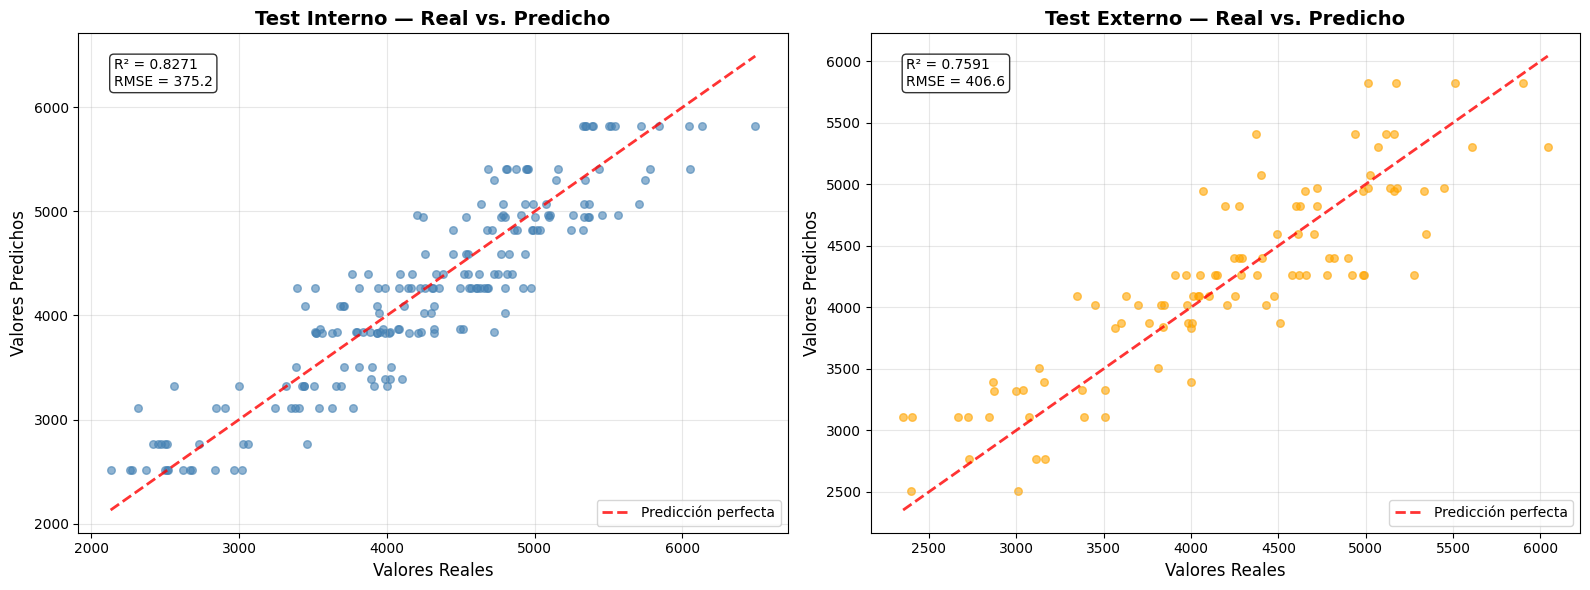

=== Correlaciones Real vs. Predicho ===
Test Interno: 0.9146
Test Externo: 0.8738
Diferencia en correlación: 0.0407


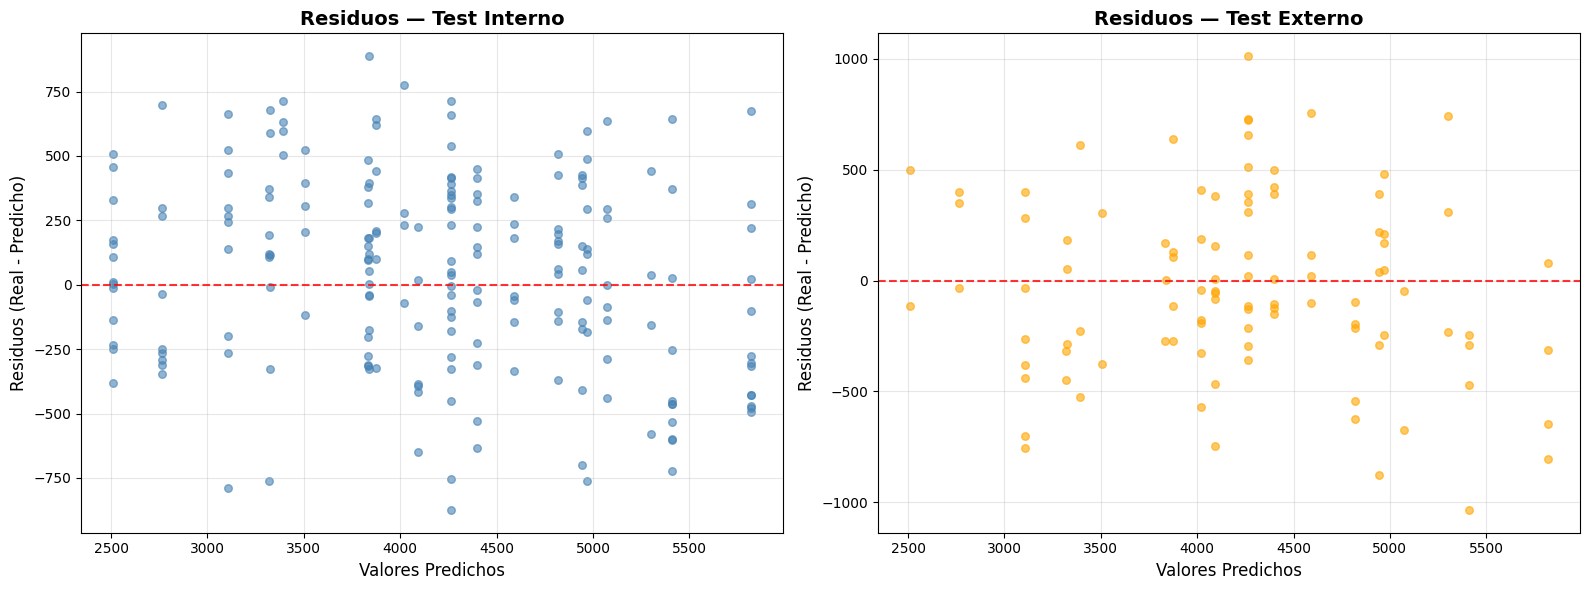

=== Estadísticas de Residuos ===
Test Interno - Media: 45.718, Std: 372.425
Test Externo - Media: -27.206, Std: 405.683


In [71]:
plt.style.use('default')
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 150

# Configurar subplots basado en disponibilidad de test externo
if test_available:
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    # Plot 1: Test Interno
    axes[0].scatter(y_test, pred_test, alpha=0.6, color='steelblue', s=30)
    lims_internal = [min(y_test.min(), pred_test.min()), max(y_test.max(), pred_test.max())]
    axes[0].plot(lims_internal, lims_internal, 'r--', alpha=0.8, linewidth=2, label='Predicción perfecta')
    axes[0].set_xlabel("Valores Reales", fontsize=12)
    axes[0].set_ylabel("Valores Predichos", fontsize=12)
    axes[0].set_title("Test Interno — Real vs. Predicho", fontsize=14, fontweight='bold')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)

    # Añadir métricas al plot interno
    r2_internal = metrics_test['R2']
    rmse_internal = metrics_test['RMSE']
    axes[0].text(0.05, 0.95, f'R² = {r2_internal:.4f}\nRMSE = {rmse_internal:.1f}',
                transform=axes[0].transAxes, verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

    # Plot 2: Test Externo
    axes[1].scatter(y_test_external, pred_external_test, alpha=0.6, color='orange', s=30)
    lims_external = [min(y_test_external.min(), pred_external_test.min()),
                     max(y_test_external.max(), pred_external_test.max())]
    axes[1].plot(lims_external, lims_external, 'r--', alpha=0.8, linewidth=2, label='Predicción perfecta')
    axes[1].set_xlabel("Valores Reales", fontsize=12)
    axes[1].set_ylabel("Valores Predichos", fontsize=12)
    axes[1].set_title("Test Externo — Real vs. Predicho", fontsize=14, fontweight='bold')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)

    # Añadir métricas al plot externo
    r2_external = metrics_external_test['R2']
    rmse_external = metrics_external_test['RMSE']
    axes[1].text(0.05, 0.95, f'R² = {r2_external:.4f}\nRMSE = {rmse_external:.1f}',
                transform=axes[1].transAxes, verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

    plt.tight_layout()
    plt.savefig(FIG_DIR / "real_vs_predicho_comparison.png", dpi=150, bbox_inches='tight')
    plt.show()

    print("=== Correlaciones Real vs. Predicho ===")
    corr_internal = np.corrcoef(y_test, pred_test)[0,1]
    corr_external = np.corrcoef(y_test_external, pred_external_test)[0,1]
    print(f"Test Interno: {corr_internal:.4f}")
    print(f"Test Externo: {corr_external:.4f}")
    print(f"Diferencia en correlación: {abs(corr_internal - corr_external):.4f}")

else:
    # Plot solo para test interno (versión original)
    plt.figure(figsize=(8, 6))
    plt.scatter(y_test, pred_test, alpha=0.6, color='steelblue', s=30)

    lims = [min(y_test.min(), pred_test.min()), max(y_test.max(), pred_test.max())]
    plt.plot(lims, lims, 'r--', alpha=0.8, linewidth=2, label='Predicción perfecta')

    plt.xlabel("Valores Reales", fontsize=12)
    plt.ylabel("Valores Predichos", fontsize=12)
    plt.title("Decision Tree — Real vs. Predicho (Test Set)", fontsize=14, fontweight='bold')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()

    plt.savefig(FIG_DIR / "real_vs_predicho_test.png", dpi=150, bbox_inches='tight')
    plt.show()

    r2 = metrics_test['R2']
    rmse = metrics_test['RMSE']
    print(f"R² = {r2:.4f} | RMSE = {rmse:.1f}")
    print(f"Correlación Real vs. Predicho: {np.corrcoef(y_test, pred_test)[0,1]:.4f}")

# Residuos comparativos si hay test externo
if test_available:
    plt.figure(figsize=(16, 6))

    # Residuos test interno
    plt.subplot(1, 2, 1)
    residuos_internal = y_test - pred_test
    plt.scatter(pred_test, residuos_internal, alpha=0.6, color='steelblue', s=30)
    plt.axhline(y=0, color='r', linestyle='--', alpha=0.8)
    plt.xlabel("Valores Predichos", fontsize=12)
    plt.ylabel("Residuos (Real - Predicho)", fontsize=12)
    plt.title("Residuos — Test Interno", fontsize=14, fontweight='bold')
    plt.grid(True, alpha=0.3)

    # Residuos test externo
    plt.subplot(1, 2, 2)
    residuos_external = y_test_external - pred_external_test
    plt.scatter(pred_external_test, residuos_external, alpha=0.6, color='orange', s=30)
    plt.axhline(y=0, color='r', linestyle='--', alpha=0.8)
    plt.xlabel("Valores Predichos", fontsize=12)
    plt.ylabel("Residuos (Real - Predicho)", fontsize=12)
    plt.title("Residuos — Test Externo", fontsize=14, fontweight='bold')
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig(FIG_DIR / "residuos_comparison.png", dpi=150, bbox_inches='tight')
    plt.show()

    # Estadísticas de residuos
    print("=== Estadísticas de Residuos ===")
    print(f"Test Interno - Media: {np.mean(residuos_internal):.3f}, Std: {np.std(residuos_internal):.3f}")
    print(f"Test Externo - Media: {np.mean(residuos_external):.3f}, Std: {np.std(residuos_external):.3f}")

else:
    plt.figure(figsize=(8, 6))
    residuos = y_test - pred_test
    plt.scatter(pred_test, residuos, alpha=0.6, color='orange', s=30)
    plt.axhline(y=0, color='r', linestyle='--', alpha=0.8)
    plt.xlabel("Valores Predichos", fontsize=12)
    plt.ylabel("Residuos (Real - Predicho)", fontsize=12)
    plt.title("Análisis de Residuos — Decision Tree", fontsize=14, fontweight='bold')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()

    plt.savefig(FIG_DIR / "residuos_test.png", dpi=150, bbox_inches='tight')
    plt.show()

## Visualización: Residuos
Analiza los residuos para detectar patrones de error, heterocedasticidad o outliers.

=== ANÁLISIS COMPARATIVO RIGUROSO DE RESIDUOS ===


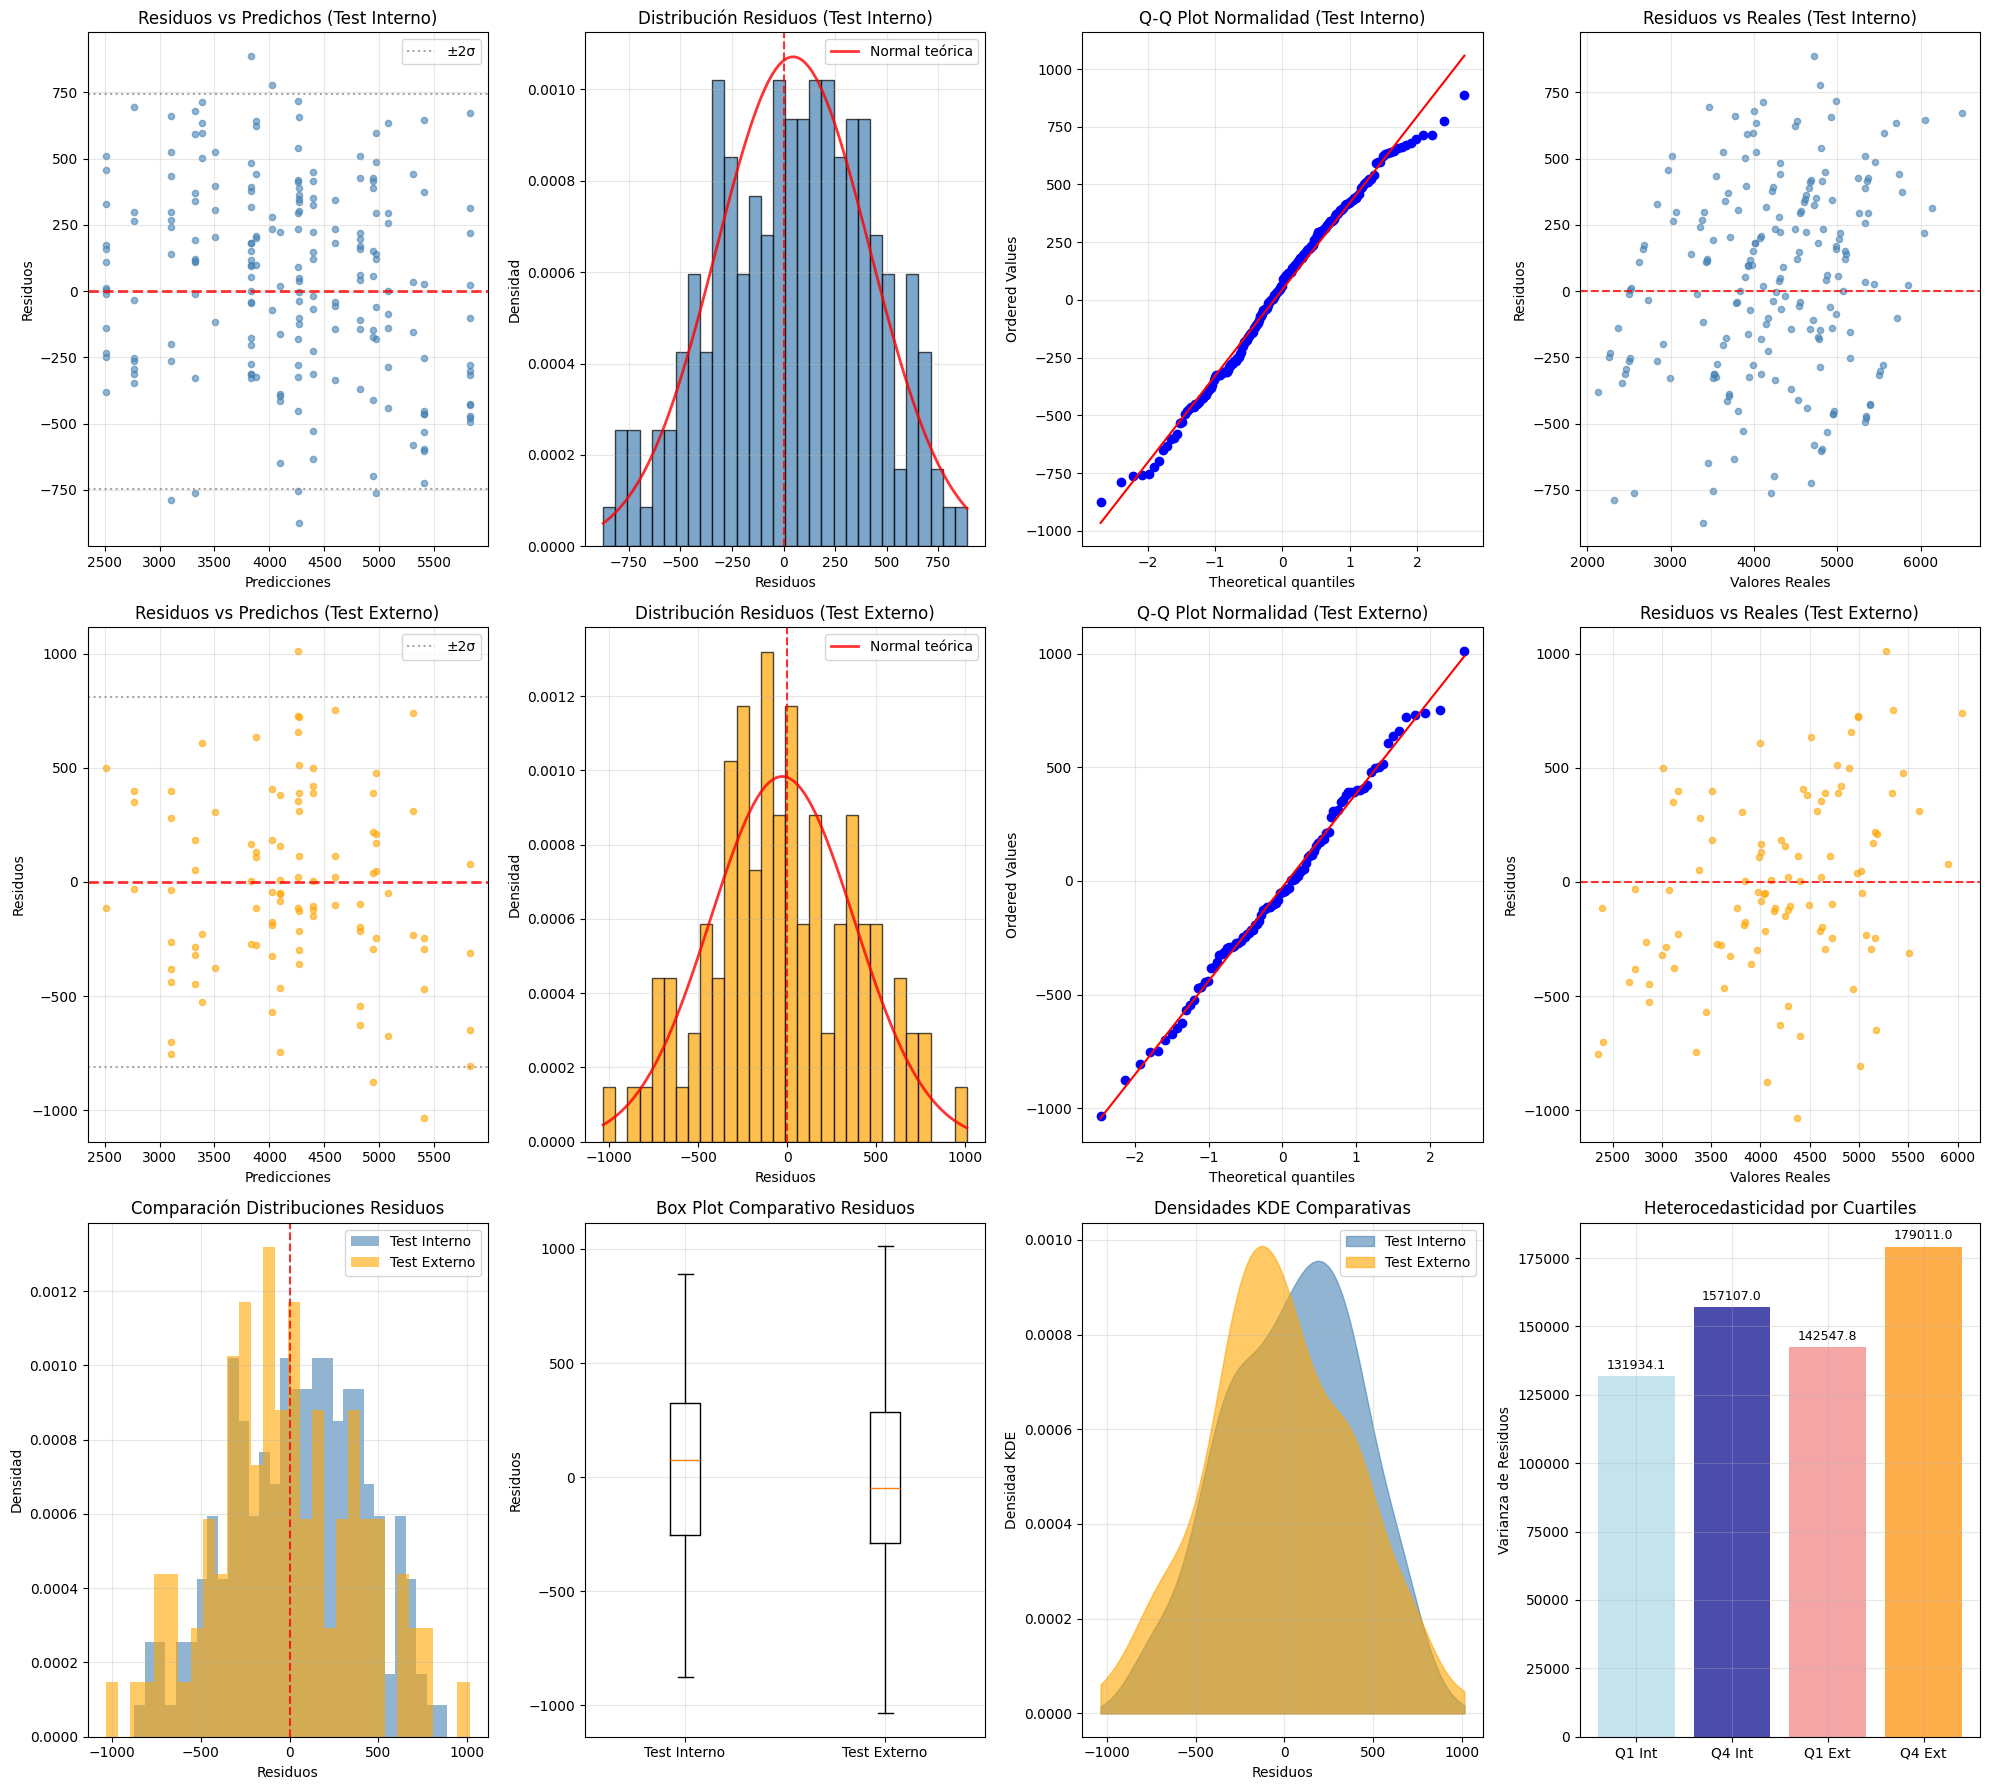


                    DIAGNÓSTICO ESTADÍSTICO DE RESIDUOS

--- TEST INTERNO ---
Media: 45.7184
Mediana: 75.2283
Desviación estándar: 372.425
Rango: [-874.77, 888.17]

🧪 Test de Normalidad (Shapiro-Wilk): p = 0.0805
   ✅ Residuos siguen distribución normal

📊 Asimetría (Skewness): -0.1884
   ✅ Distribución aproximadamente simétrica
📈 Curtosis: -0.6101
   ⚠️ Distribución platicúrtica (colas ligeras)

🎯 Análisis de Outliers:
   Outliers (>2σ): 7 (3.5%)
   Outliers (>3σ): 0 (0.0%)
   ✅ Proporción de outliers 2σ normal
   ✅ Proporción de outliers 3σ normal

--- TEST EXTERNO ---
Media: -27.2061
Mediana: -47.9278
Desviación estándar: 405.683
Rango: [-1034.93, 1012.69]

🧪 Test de Normalidad (Shapiro-Wilk): p = 0.9337
   ✅ Residuos siguen distribución normal

📊 Asimetría (Skewness): 0.0447
   ✅ Distribución aproximadamente simétrica
📈 Curtosis: -0.2798
   ✅ Curtosis normal (mesocúrtica)

🎯 Análisis de Outliers:
   Outliers (>2σ): 3 (3.0%)
   Outliers (>3σ): 0 (0.0%)
   ✅ Proporción de outliers 2

In [72]:
# ANÁLISIS RIGUROSO DE RESIDUOS
residuos_internal = y_test - pred_test

if test_available:
    residuos_external = y_test_external - pred_external_test
    print("=== ANÁLISIS COMPARATIVO RIGUROSO DE RESIDUOS ===")

    # Configurar subplots
    fig, axes = plt.subplots(3, 4, figsize=(20, 18))

    # FILA 1: ANÁLISIS TEST INTERNO
    # 1.1 Residuos vs Predichos (Interno)
    axes[0,0].scatter(pred_test, residuos_internal, alpha=0.6, color='steelblue', s=20)
    axes[0,0].axhline(y=0, color='red', linestyle='--', alpha=0.8, linewidth=2)

    std_residuos_int = np.std(residuos_internal)
    axes[0,0].axhline(y=2*std_residuos_int, color='gray', linestyle=':', alpha=0.7, label='±2σ')
    axes[0,0].axhline(y=-2*std_residuos_int, color='gray', linestyle=':', alpha=0.7)
    axes[0,0].set_xlabel("Predicciones")
    axes[0,0].set_ylabel("Residuos")
    axes[0,0].set_title("Residuos vs Predichos (Test Interno)")
    axes[0,0].legend()
    axes[0,0].grid(True, alpha=0.3)

    # 1.2 Histograma residuos (Interno)
    axes[0,1].hist(residuos_internal, bins=30, alpha=0.7, color='steelblue', edgecolor='black', density=True)
    axes[0,1].axvline(x=0, color='red', linestyle='--', alpha=0.8)

    # Superponer distribución normal teórica
    x_norm = np.linspace(residuos_internal.min(), residuos_internal.max(), 100)
    y_norm = st.norm.pdf(x_norm, np.mean(residuos_internal), std_residuos_int)
    axes[0,1].plot(x_norm, y_norm, 'r-', linewidth=2, alpha=0.8, label='Normal teórica')

    axes[0,1].set_xlabel("Residuos")
    axes[0,1].set_ylabel("Densidad")
    axes[0,1].set_title("Distribución Residuos (Test Interno)")
    axes[0,1].legend()
    axes[0,1].grid(True, alpha=0.3)

    # 1.3 Q-Q plot (Interno)
    st.probplot(residuos_internal, dist="norm", plot=axes[0,2])
    axes[0,2].set_title("Q-Q Plot Normalidad (Test Interno)")
    axes[0,2].grid(True, alpha=0.3)

    # 1.4 Residuos vs Valores Reales (Interno)
    axes[0,3].scatter(y_test, residuos_internal, alpha=0.6, color='steelblue', s=20)
    axes[0,3].axhline(y=0, color='red', linestyle='--', alpha=0.8)
    axes[0,3].set_xlabel("Valores Reales")
    axes[0,3].set_ylabel("Residuos")
    axes[0,3].set_title("Residuos vs Reales (Test Interno)")
    axes[0,3].grid(True, alpha=0.3)

    # FILA 2: ANÁLISIS TEST EXTERNO
    # 2.1 Residuos vs Predichos (Externo)
    axes[1,0].scatter(pred_external_test, residuos_external, alpha=0.6, color='orange', s=20)
    axes[1,0].axhline(y=0, color='red', linestyle='--', alpha=0.8, linewidth=2)

    std_residuos_ext = np.std(residuos_external)
    axes[1,0].axhline(y=2*std_residuos_ext, color='gray', linestyle=':', alpha=0.7, label='±2σ')
    axes[1,0].axhline(y=-2*std_residuos_ext, color='gray', linestyle=':', alpha=0.7)
    axes[1,0].set_xlabel("Predicciones")
    axes[1,0].set_ylabel("Residuos")
    axes[1,0].set_title("Residuos vs Predichos (Test Externo)")
    axes[1,0].legend()
    axes[1,0].grid(True, alpha=0.3)

    # 2.2 Histograma residuos (Externo)
    axes[1,1].hist(residuos_external, bins=30, alpha=0.7, color='orange', edgecolor='black', density=True)
    axes[1,1].axvline(x=0, color='red', linestyle='--', alpha=0.8)

    x_norm_ext = np.linspace(residuos_external.min(), residuos_external.max(), 100)
    y_norm_ext = st.norm.pdf(x_norm_ext, np.mean(residuos_external), std_residuos_ext)
    axes[1,1].plot(x_norm_ext, y_norm_ext, 'r-', linewidth=2, alpha=0.8, label='Normal teórica')

    axes[1,1].set_xlabel("Residuos")
    axes[1,1].set_ylabel("Densidad")
    axes[1,1].set_title("Distribución Residuos (Test Externo)")
    axes[1,1].legend()
    axes[1,1].grid(True, alpha=0.3)

    # 2.3 Q-Q plot (Externo)
    st.probplot(residuos_external, dist="norm", plot=axes[1,2])
    axes[1,2].set_title("Q-Q Plot Normalidad (Test Externo)")
    axes[1,2].grid(True, alpha=0.3)

    # 2.4 Residuos vs Valores Reales (Externo)
    axes[1,3].scatter(y_test_external, residuos_external, alpha=0.6, color='orange', s=20)
    axes[1,3].axhline(y=0, color='red', linestyle='--', alpha=0.8)
    axes[1,3].set_xlabel("Valores Reales")
    axes[1,3].set_ylabel("Residuos")
    axes[1,3].set_title("Residuos vs Reales (Test Externo)")
    axes[1,3].grid(True, alpha=0.3)

    # FILA 3: ANÁLISIS COMPARATIVO
    # 3.1 Comparación de distribuciones
    axes[2,0].hist(residuos_internal, bins=30, alpha=0.6, color='steelblue',
                   density=True, label='Test Interno')
    axes[2,0].hist(residuos_external, bins=30, alpha=0.6, color='orange',
                   density=True, label='Test Externo')
    axes[2,0].axvline(x=0, color='red', linestyle='--', alpha=0.8)
    axes[2,0].set_xlabel("Residuos")
    axes[2,0].set_ylabel("Densidad")
    axes[2,0].set_title("Comparación Distribuciones Residuos")
    axes[2,0].legend()
    axes[2,0].grid(True, alpha=0.3)

    # 3.2 Box plot comparativo
    axes[2,1].boxplot([residuos_internal, residuos_external],
                      labels=['Test Interno', 'Test Externo'])
    axes[2,1].set_ylabel("Residuos")
    axes[2,1].set_title("Box Plot Comparativo Residuos")
    axes[2,1].grid(True, alpha=0.3)

    # 3.3 Scatter plot residuos vs residuos
    if len(residuos_internal) == len(residuos_external):
        axes[2,2].scatter(residuos_internal, residuos_external, alpha=0.6, color='green', s=20)
        axes[2,2].plot([residuos_internal.min(), residuos_internal.max()],
                       [residuos_internal.min(), residuos_internal.max()],
                       'r--', alpha=0.8, label='Residuos = Residuos')
        axes[2,2].set_xlabel("Residuos Test Interno")
        axes[2,2].set_ylabel("Residuos Test Externo")
        axes[2,2].set_title("Residuos Interno vs Externo")
        axes[2,2].legend()
    else:
        # Si diferentes tamaños, mostrar densidades
        from sklearn.neighbors import KernelDensity
        kde_int = KernelDensity(bandwidth=std_residuos_int/3)
        kde_ext = KernelDensity(bandwidth=std_residuos_ext/3)

        x_range = np.linspace(min(residuos_internal.min(), residuos_external.min()),
                             max(residuos_internal.max(), residuos_external.max()), 300)

        kde_int.fit(residuos_internal.values.reshape(-1, 1))
        kde_ext.fit(residuos_external.values.reshape(-1, 1))

        density_int = np.exp(kde_int.score_samples(x_range.reshape(-1, 1)))
        density_ext = np.exp(kde_ext.score_samples(x_range.reshape(-1, 1)))

        axes[2,2].fill_between(x_range, density_int, alpha=0.6, color='steelblue', label='Test Interno')
        axes[2,2].fill_between(x_range, density_ext, alpha=0.6, color='orange', label='Test Externo')
        axes[2,2].set_xlabel("Residuos")
        axes[2,2].set_ylabel("Densidad KDE")
        axes[2,2].set_title("Densidades KDE Comparativas")
        axes[2,2].legend()
    axes[2,2].grid(True, alpha=0.3)

    # 3.4 Análisis de varianza por cuartiles
    # Dividir en cuartiles y analizar varianza
    q1_int, q3_int = np.percentile(pred_test, [25, 75])
    q1_ext, q3_ext = np.percentile(pred_external_test, [25, 75])

    # Calcular varianzas por cuartiles
    residuos_q1_int = residuos_internal[pred_test <= q1_int]
    residuos_q4_int = residuos_internal[pred_test >= q3_int]
    residuos_q1_ext = residuos_external[pred_external_test <= q1_ext]
    residuos_q4_ext = residuos_external[pred_external_test >= q3_ext]

    vars_cuartiles = [np.var(residuos_q1_int), np.var(residuos_q4_int),
                      np.var(residuos_q1_ext), np.var(residuos_q4_ext)]

    bars = axes[2,3].bar(['Q1 Int', 'Q4 Int', 'Q1 Ext', 'Q4 Ext'],
                         vars_cuartiles,
                         color=['lightblue', 'darkblue', 'lightcoral', 'darkorange'],
                         alpha=0.7)
    axes[2,3].set_ylabel("Varianza de Residuos")
    axes[2,3].set_title("Heterocedasticidad por Cuartiles")
    axes[2,3].grid(True, alpha=0.3)

    # Añadir valores en las barras
    for bar, var in zip(bars, vars_cuartiles):
        height = bar.get_height()
        axes[2,3].text(bar.get_x() + bar.get_width()/2., height + height*0.01,
                       f'{var:.1f}', ha='center', va='bottom', fontsize=9)

    plt.tight_layout()
    plt.savefig(FIG_DIR / "analisis_residuos_completo_comparativo.png", dpi=150, bbox_inches='tight')
    plt.show()

else:
    # Análisis de residuos solo para test interno
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))

    # 1. Residuos vs Predichos
    axes[0,0].scatter(pred_test, residuos_internal, alpha=0.6, color='steelblue', s=30)
    axes[0,0].axhline(y=0, color='red', linestyle='--', alpha=0.8, linewidth=2)

    std_residuos = np.std(residuos_internal)
    axes[0,0].axhline(y=2*std_residuos, color='gray', linestyle=':', alpha=0.7, label='±2σ')
    axes[0,0].axhline(y=-2*std_residuos, color='gray', linestyle=':', alpha=0.7)
    axes[0,0].set_xlabel("Valores Predichos")
    axes[0,0].set_ylabel("Residuos")
    axes[0,0].set_title("Residuos vs Predichos")
    axes[0,0].legend()
    axes[0,0].grid(True, alpha=0.3)

    # 2. Histograma de residuos con curva normal
    axes[0,1].hist(residuos_internal, bins=30, alpha=0.7, color='skyblue', edgecolor='black', density=True)
    axes[0,1].axvline(x=0, color='red', linestyle='--', alpha=0.8)

    # Superponer distribución normal teórica
    x_norm = np.linspace(residuos_internal.min(), residuos_internal.max(), 100)
    y_norm = st.norm.pdf(x_norm, np.mean(residuos_internal), std_residuos)
    axes[0,1].plot(x_norm, y_norm, 'r-', linewidth=2, alpha=0.8, label='Normal teórica')

    axes[0,1].set_xlabel("Residuos")
    axes[0,1].set_ylabel("Densidad")
    axes[0,1].set_title("Distribución de Residuos")
    axes[0,1].legend()
    axes[0,1].grid(True, alpha=0.3)

    # 3. Q-Q plot para normalidad
    st.probplot(residuos_internal, dist="norm", plot=axes[1,0])
    axes[1,0].set_title("Q-Q Plot (Normalidad)")
    axes[1,0].grid(True, alpha=0.3)

    # 4. Residuos vs Real
    axes[1,1].scatter(y_test, residuos_internal, alpha=0.6, color='green', s=30)
    axes[1,1].axhline(y=0, color='red', linestyle='--', alpha=0.8)
    axes[1,1].set_xlabel("Valores Reales")
    axes[1,1].set_ylabel("Residuos")
    axes[1,1].set_title("Residuos vs Valores Reales")
    axes[1,1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig(FIG_DIR / "residuos_completo.png", dpi=150, bbox_inches='tight')
    plt.show()

# DIAGNÓSTICO ESTADÍSTICO RIGUROSO DE RESIDUOS
print("\n" + "="*60)
print("                    DIAGNÓSTICO ESTADÍSTICO DE RESIDUOS")
print("="*60)

def diagnostico_residuos(residuos, nombre=""):
    print(f"\n--- {nombre} ---")

    # Estadísticas básicas
    media = np.mean(residuos)
    std = np.std(residuos)
    mediana = np.median(residuos)

    print(f"Media: {media:.4f}")
    print(f"Mediana: {mediana:.4f}")
    print(f"Desviación estándar: {std:.3f}")
    print(f"Rango: [{np.min(residuos):.2f}, {np.max(residuos):.2f}]")

    # Tests estadísticos
    # 1. Test de normalidad (Shapiro-Wilk)
    if len(residuos) <= 5000:
        _, p_shapiro = st.shapiro(residuos)
    else:
        _, p_shapiro = st.shapiro(residuos.sample(5000))

    print(f"\n🧪 Test de Normalidad (Shapiro-Wilk): p = {p_shapiro:.4f}")
    if p_shapiro > 0.05:
        print("   ✅ Residuos siguen distribución normal")
    else:
        print("   ⚠️ Residuos NO siguen distribución normal")

    # 2. Test de simetría (skewness)
    skewness = st.skew(residuos)
    print(f"\n📊 Asimetría (Skewness): {skewness:.4f}")
    if abs(skewness) < 0.5:
        print("   ✅ Distribución aproximadamente simétrica")
    elif abs(skewness) < 1:
        print("   ⚠️ Asimetría moderada")
    else:
        print("   ❌ Asimetría pronunciada")

    # 3. Test de curtosis
    kurt = st.kurtosis(residuos)
    print(f"📈 Curtosis: {kurt:.4f}")
    if abs(kurt) < 0.5:
        print("   ✅ Curtosis normal (mesocúrtica)")
    elif kurt > 0.5:
        print("   ⚠️ Distribución leptocúrtica (colas pesadas)")
    else:
        print("   ⚠️ Distribución platicúrtica (colas ligeras)")

    # 4. Análisis de outliers
    outliers_2sigma = np.abs(residuos) > 2*std
    outliers_3sigma = np.abs(residuos) > 3*std

    print(f"\n🎯 Análisis de Outliers:")
    print(f"   Outliers (>2σ): {np.sum(outliers_2sigma)} ({100*np.mean(outliers_2sigma):.1f}%)")
    print(f"   Outliers (>3σ): {np.sum(outliers_3sigma)} ({100*np.mean(outliers_3sigma):.1f}%)")

    # Esperado teóricamente: 2σ ≈ 5%, 3σ ≈ 0.3%
    if np.mean(outliers_2sigma) <= 0.05:
        print("   ✅ Proporción de outliers 2σ normal")
    else:
        print("   ⚠️ Exceso de outliers 2σ")

    if np.mean(outliers_3sigma) <= 0.003:
        print("   ✅ Proporción de outliers 3σ normal")
    else:
        print("   ⚠️ Exceso de outliers 3σ")

    return {
        'media': media, 'std': std, 'skewness': skewness, 'kurtosis': kurt,
        'p_normalidad': p_shapiro, 'outliers_2s': np.mean(outliers_2sigma),
        'outliers_3s': np.mean(outliers_3sigma)
    }

# Diagnosticar residuos
diag_interno = diagnostico_residuos(residuos_internal, "TEST INTERNO")

if test_available:
    diag_externo = diagnostico_residuos(residuos_external, "TEST EXTERNO")

    # Comparación estadística entre residuos
    print(f"\n🔬 COMPARACIÓN ESTADÍSTICA ENTRE RESIDUOS")

    # Test de igualdad de varianzas
    _, p_levene_res = st.levene(residuos_internal, residuos_external)
    print(f"Test de Levene (igualdad varianzas): p = {p_levene_res:.4f}")
    if p_levene_res > 0.05:
        print("   ✅ Varianzas homogéneas")
    else:
        print("   ⚠️ Varianzas heterogéneas")

    # Test de igualdad de distribuciones
    _, p_ks_res = st.ks_2samp(residuos_internal, residuos_external)
    print(f"Test K-S (igualdad distribuciones): p = {p_ks_res:.4f}")
    if p_ks_res > 0.05:
        print("   ✅ Distribuciones de residuos similares")
    else:
        print("   ⚠️ Distribuciones de residuos diferentes")

    # Score de calidad de residuos
    print(f"\n📈 SCORE DE CALIDAD DE RESIDUOS")

    criterios_interno = [
        diag_interno['p_normalidad'] > 0.05,
        abs(diag_interno['skewness']) < 0.5,
        abs(diag_interno['kurtosis']) < 1,
        diag_interno['outliers_2s'] <= 0.08,
        diag_interno['outliers_3s'] <= 0.005
    ]

    criterios_externo = [
        diag_externo['p_normalidad'] > 0.05,
        abs(diag_externo['skewness']) < 0.5,
        abs(diag_externo['kurtosis']) < 1,
        diag_externo['outliers_2s'] <= 0.08,
        diag_externo['outliers_3s'] <= 0.005
    ]

    criterios_comparacion = [
        p_levene_res > 0.05,
        p_ks_res > 0.05
    ]

    score_interno = sum(criterios_interno) / len(criterios_interno)
    score_externo = sum(criterios_externo) / len(criterios_externo)
    score_comparacion = sum(criterios_comparacion) / len(criterios_comparacion)
    score_global = (score_interno + score_externo + score_comparacion) / 3

    print(f"Score Test Interno: {score_interno:.2%}")
    print(f"Score Test Externo: {score_externo:.2%}")
    print(f"Score Comparación: {score_comparacion:.2%}")
    print(f"Score Global Residuos: {score_global:.2%}")

    if score_global >= 0.8:
        print("🏆 RESIDUOS DE EXCELENTE CALIDAD")
    elif score_global >= 0.6:
        print("✅ RESIDUOS DE BUENA CALIDAD")
    else:
        print("⚠️ RESIDUOS REQUIEREN ATENCIÓN")

else:
    # Score solo para test interno
    criterios_interno = [
        diag_interno['p_normalidad'] > 0.05,
        abs(diag_interno['skewness']) < 0.5,
        abs(diag_interno['kurtosis']) < 1,
        diag_interno['outliers_2s'] <= 0.08,
        diag_interno['outliers_3s'] <= 0.005
    ]

    score_interno = sum(criterios_interno) / len(criterios_interno)
    print(f"\n📈 Score de Calidad Residuos: {score_interno:.2%}")

    if score_interno >= 0.8:
        print("🏆 RESIDUOS DE EXCELENTE CALIDAD")
    elif score_interno >= 0.6:
        print("✅ RESIDUOS DE BUENA CALIDAD")
    else:
        print("⚠️ RESIDUOS REQUIEREN ATENCIÓN")

## Importancia de variables
Mide la contribución relativa de cada feature para explicar la predicción, útil para interpretación y comunicación.

=== ANÁLISIS CIENTÍFICO DE IMPORTANCIA DE VARIABLES ===
Modelo optimizado - Profundidad: 6
Total de features: 9

📊 ESTADÍSTICAS DE IMPORTANCIA
Media: 0.1111
Mediana: 0.0445
Desviación estándar: 0.2170
Coeficiente de variación: 1.95

🎯 CLASIFICACIÓN DE VARIABLES
Variables críticas (≥5%): 4
Variables moderadas (1-5%): 1
Variables menores (<1%): 4

=== TOP 15 VARIABLES MÁS IMPORTANTES ===


,Importancia,Importancia_Pct,Acumulado_Pct,Ranking
Square Footage,0.678393,67.84,67.84,1
Building Type_Industrial,0.121293,12.13,79.97,2
Building Type_Residential,0.074504,7.45,87.42,3
Appliances Used,0.072728,7.27,94.69,4
Number of Occupants,0.044503,4.45,99.14,5
Building Type_Commercial,0.008579,0.86,100.00,6
Average Temperature,0.000000,0.00,100.00,7
Day of Week_Weekday,0.000000,0.00,100.00,8
Day of Week_Weekend,0.000000,0.00,100.00,9



📈 ANÁLISIS DE CONCENTRACIÓN DE IMPORTANCIA
Top 5 variables explican: 99.1% del modelo
Top 10 variables explican: 100.0% del modelo
Top 20 variables explican: 100.0% del modelo
Índice de Gini (concentración): 0.731
   ⚠️ Importancia altamente concentrada

🔬 ANÁLISIS DE ESTABILIDAD DE IMPORTANCIAS
=== ANÁLISIS DE ESTABILIDAD (Bootstrap) ===
=== ANÁLISIS DE ESTABILIDAD (Bootstrap) ===


,Variable,Importancia_Original,Importancia_Bootstrap_Mean,Importancia_Bootstrap_Std,CV_Bootstrap,Estabilidad_Score
Square Footage,Day of Week_Weekend,0.678393,0.667304,0.025816,0.038687,0.996131
Building Type_Industrial,Average Temperature,0.121293,0.083013,0.055991,0.674484,0.932552
Building Type_Residential,Building Type_Commercial,0.074504,0.100396,0.058773,0.585416,0.941458
Appliances Used,Square Footage,0.072728,0.066345,0.020123,0.303308,0.969669
Number of Occupants,Day of Week_Weekday,0.044503,0.071393,0.022522,0.315466,0.968453
Building Type_Commercial,Appliances Used,0.008579,0.011267,0.010776,0.956447,0.904355
Average Temperature,Number of Occupants,0.000000,0.000241,0.000866,3.595515,0.640449
Day of Week_Weekday,Building Type_Industrial,0.000000,0.000008,0.000083,10.000000,0.000000
Day of Week_Weekend,Building Type_Residential,0.000000,0.000034,0.000273,8.085646,0.191435



Variables estables (CV < 0.5): 3
Variables inestables (CV ≥ 0.5): 6


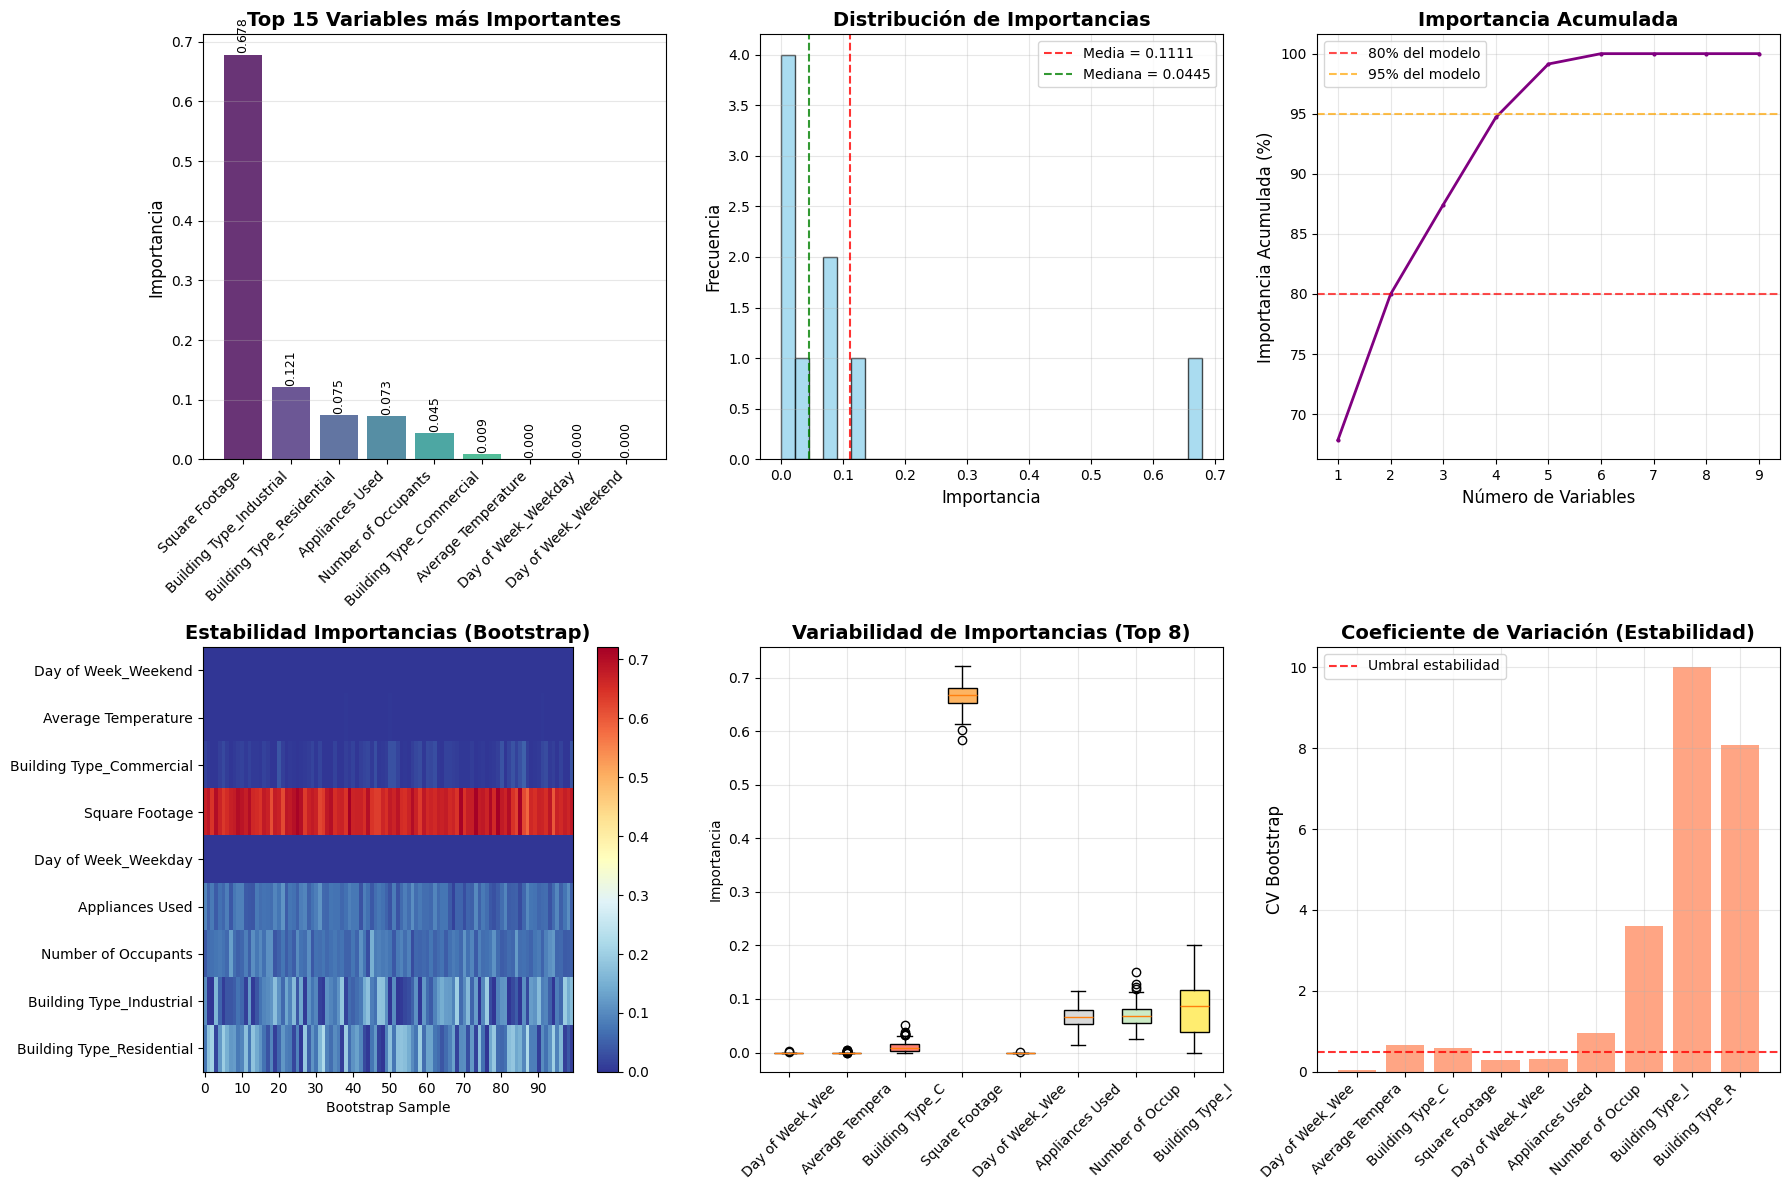


🔗 ANÁLISIS DE ESTRUCTURA DEL ÁRBOL
Variables utilizadas en el árbol: 6
Total de nodos de decisión: 22

📊 FRECUENCIA DE USO EN NODOS (Top 10):


Appliances Used              8
Square Footage               7
Number of Occupants          3
Building Type_Industrial     2
Building Type_Commercial     1
Building Type_Residential    1
Name: count, dtype: int64


Correlación importancia-frecuencia: 0.545
   ⚠️ Correlación moderada

                    RESUMEN DE INTERPRETABILIDAD
Variables con importancia = 0: 3
Variables con importancia < 1%: 4
Variable más importante: Square Footage (0.678)

📈 Score de Interpretabilidad: 50.00%
✅ MODELO MODERADAMENTE INTERPRETABLE
Estructura razonable con algunas limitaciones

💾 Ranking de importancias guardado en: /Users/cristian/Desktop/Project-Regression-Equipo-2 copia/data/figures/feature_importance_ranking.csv


In [73]:
# ANÁLISIS RIGUROSO DE IMPORTANCIA DE VARIABLES
importances = pd.Series(best_dt.feature_importances_, index=X.columns).sort_values(ascending=False)

print("=== ANÁLISIS CIENTÍFICO DE IMPORTANCIA DE VARIABLES ===")
print(f"Modelo optimizado - Profundidad: {best_dt.max_depth}")
print(f"Total de features: {len(importances)}")

# Crear DataFrame completo de importancias
importance_df = importances.to_frame("Importancia")
importance_df['Importancia_Pct'] = (importance_df['Importancia'] * 100).round(2)
importance_df['Acumulado_Pct'] = importance_df['Importancia_Pct'].cumsum()
importance_df['Ranking'] = range(1, len(importance_df) + 1)

# Análisis estadístico de importancias
print(f"\n📊 ESTADÍSTICAS DE IMPORTANCIA")
print(f"Media: {importances.mean():.4f}")
print(f"Mediana: {importances.median():.4f}")
print(f"Desviación estándar: {importances.std():.4f}")
print(f"Coeficiente de variación: {importances.std()/importances.mean():.2f}")

# Identificar variables críticas
variables_criticas = importances[importances >= 0.05]  # >5%
variables_moderadas = importances[(importances >= 0.01) & (importances < 0.05)]  # 1-5%
variables_menores = importances[importances < 0.01]  # <1%

print(f"\n🎯 CLASIFICACIÓN DE VARIABLES")
print(f"Variables críticas (≥5%): {len(variables_criticas)}")
print(f"Variables moderadas (1-5%): {len(variables_moderadas)}")
print(f"Variables menores (<1%): {len(variables_menores)}")

print(f"\n=== TOP 15 VARIABLES MÁS IMPORTANTES ===")
display(importance_df.head(15))

# Análisis de concentración
top5_sum = importances.head(5).sum()
top10_sum = importances.head(10).sum()
top20_sum = importances.head(20).sum()

print(f"\n📈 ANÁLISIS DE CONCENTRACIÓN DE IMPORTANCIA")
print(f"Top 5 variables explican: {top5_sum:.1%} del modelo")
print(f"Top 10 variables explican: {top10_sum:.1%} del modelo")
print(f"Top 20 variables explican: {top20_sum:.1%} del modelo")

# Calcular el índice de Gini para medir concentración
def gini_coefficient(x):
    # Calcular coeficiente de Gini
    sorted_x = np.sort(x)
    n = len(x)
    cumsum_x = np.cumsum(sorted_x)
    return (n + 1 - 2 * np.sum(cumsum_x) / cumsum_x[-1]) / n

gini_importance = gini_coefficient(importances.values)
print(f"Índice de Gini (concentración): {gini_importance:.3f}")
if gini_importance < 0.5:
    print("   ✅ Importancia distribuida equitativamente")
elif gini_importance < 0.7:
    print("   ⚠️ Importancia moderadamente concentrada")
else:
    print("   ⚠️ Importancia altamente concentrada")

# ANÁLISIS DE ESTABILIDAD DE IMPORTANCIAS
print(f"\n🔬 ANÁLISIS DE ESTABILIDAD DE IMPORTANCIAS")

# Bootstrap de importancias para evaluar estabilidad
from sklearn.utils import resample
n_bootstrap = 100  # Reducido para eficiencia
bootstrap_importances = []

for i in range(n_bootstrap):
    # Resample training data
    indices = resample(range(len(X_train)), n_samples=len(X_train))
    X_boot = X_train.iloc[indices]
    y_boot = y_train.iloc[indices]

    # Entrenar modelo con mismos hiperparámetros
    dt_boot = DecisionTreeRegressor(**best_dt.get_params())
    dt_boot.fit(X_boot, y_boot)

    # Guardar importancias
    boot_imp = pd.Series(dt_boot.feature_importances_, index=X.columns)
    bootstrap_importances.append(boot_imp)

# Convertir a DataFrame
bootstrap_df = pd.DataFrame(bootstrap_importances)

# Calcular estadísticas de estabilidad
importance_mean = bootstrap_df.mean()
importance_std = bootstrap_df.std()
importance_cv = importance_std / importance_mean  # Coeficiente de variación

# Crear tabla de estabilidad para top variables
stability_df = pd.DataFrame({
    'Variable': importance_mean.index,
    'Importancia_Original': importances,
    'Importancia_Bootstrap_Mean': importance_mean,
    'Importancia_Bootstrap_Std': importance_std,
    'CV_Bootstrap': importance_cv,
    'Estabilidad_Score': 1 - (importance_cv / importance_cv.max())  # Normalizado
}).sort_values('Importancia_Original', ascending=False)

print("=== ANÁLISIS DE ESTABILIDAD (Bootstrap) ===")
display(stability_df.head(10))

# Identificar variables estables vs inestables
variables_estables = stability_df[stability_df['CV_Bootstrap'] < 0.5]['Variable']
variables_inestables = stability_df[stability_df['CV_Bootstrap'] >= 0.5]['Variable']

print(f"\nVariables estables (CV < 0.5): {len(variables_estables)}")
print(f"Variables inestables (CV ≥ 0.5): {len(variables_inestables)}")

# VISUALIZACIÓN MEJORADA
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# 1. Top 15 variables (barplot mejorado)
top15 = importances.head(15)
colors = plt.cm.viridis(np.linspace(0, 1, len(top15)))
bars = axes[0,0].bar(range(len(top15)), top15.values, color=colors, alpha=0.8)
axes[0,0].set_xticks(range(len(top15)))
axes[0,0].set_xticklabels(top15.index, rotation=45, ha='right')
axes[0,0].set_title("Top 15 Variables más Importantes", fontsize=14, fontweight='bold')
axes[0,0].set_ylabel("Importancia", fontsize=12)
axes[0,0].grid(True, alpha=0.3, axis='y')

# Añadir valores en las barras
for i, bar in enumerate(bars):
    height = bar.get_height()
    axes[0,0].text(bar.get_x() + bar.get_width()/2., height + 0.002,
                   f'{height:.3f}', ha='center', va='bottom', fontsize=9, rotation=90)

# 2. Distribución de todas las importancias
axes[0,1].hist(importances.values, bins=30, color='skyblue', alpha=0.7, edgecolor='black')
axes[0,1].axvline(importances.mean(), color='red', linestyle='--', alpha=0.8, label=f'Media = {importances.mean():.4f}')
axes[0,1].axvline(importances.median(), color='green', linestyle='--', alpha=0.8, label=f'Mediana = {importances.median():.4f}')
axes[0,1].set_title("Distribución de Importancias", fontsize=14, fontweight='bold')
axes[0,1].set_xlabel("Importancia", fontsize=12)
axes[0,1].set_ylabel("Frecuencia", fontsize=12)
axes[0,1].legend()
axes[0,1].grid(True, alpha=0.3)

# 3. Curva de importancia acumulada
axes[0,2].plot(range(1, len(importances)+1), importance_df['Acumulado_Pct'],
               color='purple', linewidth=2, marker='o', markersize=2)
axes[0,2].axhline(y=80, color='red', linestyle='--', alpha=0.7, label='80% del modelo')
axes[0,2].axhline(y=95, color='orange', linestyle='--', alpha=0.7, label='95% del modelo')
axes[0,2].set_title("Importancia Acumulada", fontsize=14, fontweight='bold')
axes[0,2].set_xlabel("Número de Variables", fontsize=12)
axes[0,2].set_ylabel("Importancia Acumulada (%)", fontsize=12)
axes[0,2].legend()
axes[0,2].grid(True, alpha=0.3)

# 4. Heatmap de estabilidad (top 10)
top10_stability = stability_df.head(10)
stability_matrix = bootstrap_df[top10_stability['Variable']].T

im = axes[1,0].imshow(stability_matrix.values, cmap='RdYlBu_r', aspect='auto')
axes[1,0].set_xticks(range(0, n_bootstrap, 10))
axes[1,0].set_yticks(range(len(top10_stability)))
axes[1,0].set_yticklabels(top10_stability['Variable'])
axes[1,0].set_title("Estabilidad Importancias (Bootstrap)", fontsize=14, fontweight='bold')
axes[1,0].set_xlabel("Bootstrap Sample")
plt.colorbar(im, ax=axes[1,0])

# 5. Box plot de estabilidad para top 8
top8_vars = stability_df.head(8)['Variable']
bootstrap_data = [bootstrap_df[var].values for var in top8_vars]
box_plot = axes[1,1].boxplot(bootstrap_data, labels=[var[:15] for var in top8_vars], patch_artist=True)

# Colorear las cajas
colors_box = plt.cm.Set3(np.linspace(0, 1, len(top8_vars)))
for patch, color in zip(box_plot['boxes'], colors_box):
    patch.set_facecolor(color)

axes[1,1].set_title("Variabilidad de Importancias (Top 8)", fontsize=14, fontweight='bold')
axes[1,1].set_ylabel("Importancia")
axes[1,1].tick_params(axis='x', rotation=45)
axes[1,1].grid(True, alpha=0.3)

# 6. Coeficientes de variación
cv_top10 = stability_df.head(10)
bars_cv = axes[1,2].bar(range(len(cv_top10)), cv_top10['CV_Bootstrap'],
                        color='coral', alpha=0.7)
axes[1,2].axhline(y=0.5, color='red', linestyle='--', alpha=0.8, label='Umbral estabilidad')
axes[1,2].set_xticks(range(len(cv_top10)))
axes[1,2].set_xticklabels([var[:15] for var in cv_top10['Variable']], rotation=45, ha='right')
axes[1,2].set_title("Coeficiente de Variación (Estabilidad)", fontsize=14, fontweight='bold')
axes[1,2].set_ylabel("CV Bootstrap", fontsize=12)
axes[1,2].legend()
axes[1,2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(FIG_DIR / "feature_importance_completo.png", dpi=150, bbox_inches='tight')
plt.show()

# ANÁLISIS DE INTERACCIONES ENTRE FEATURES (para Decision Trees)
print(f"\n🔗 ANÁLISIS DE ESTRUCTURA DEL ÁRBOL")

# Análizar qué variables aparecen juntas en ramas
feature_used_indices = [i for i in best_dt.tree_.feature if i >= 0]
feature_used_names = [X.columns[i] for i in feature_used_indices]
unique_features_used = list(set(feature_used_names))

print(f"Variables utilizadas en el árbol: {len(unique_features_used)}")
print(f"Total de nodos de decisión: {len(feature_used_indices)}")

# Frecuencia de uso en nodos
feature_usage = pd.Series(feature_used_names).value_counts()
print(f"\n📊 FRECUENCIA DE USO EN NODOS (Top 10):")
display(feature_usage.head(10))

# Correlación entre importancia y frecuencia de uso
if len(feature_usage) > 1:
    # Alinear las series
    common_features = list(set(importances.index) & set(feature_usage.index))
    if len(common_features) > 3:
        imp_aligned = importances[common_features]
        usage_aligned = feature_usage[common_features]

        correlation = np.corrcoef(imp_aligned, usage_aligned)[0,1]
        print(f"\nCorrelación importancia-frecuencia: {correlation:.3f}")
        if correlation > 0.7:
            print("   ✅ Alta correlación: importancia = frecuencia de uso")
        elif correlation > 0.4:
            print("   ⚠️ Correlación moderada")
        else:
            print("   ❌ Baja correlación: revisar estructura del árbol")

# RESUMEN FINAL DE INTERPRETABILIDAD
print(f"\n" + "="*60)
print("                    RESUMEN DE INTERPRETABILIDAD")
print("="*60)

zero_importance = (importances == 0).sum()
low_importance = (importances < 0.01).sum()

print(f"Variables con importancia = 0: {zero_importance}")
print(f"Variables con importancia < 1%: {low_importance}")
print(f"Variable más importante: {importances.index[0]} ({importances.iloc[0]:.3f})")

# Score de interpretabilidad
interpretability_indicators = [
    gini_importance < 0.7,  # No muy concentrada
    len(variables_criticas) >= 3,  # Al menos 3 variables críticas
    len(variables_estables) >= 5,  # Al menos 5 variables estables
    top10_sum > 0.8  # Top 10 explican >80%
]

interpretability_score = sum(interpretability_indicators) / len(interpretability_indicators)
print(f"\n📈 Score de Interpretabilidad: {interpretability_score:.2%}")

if interpretability_score >= 0.75:
    print("🏆 MODELO ALTAMENTE INTERPRETABLE")
    print("Estructura clara y variables estables")
elif interpretability_score >= 0.5:
    print("✅ MODELO MODERADAMENTE INTERPRETABLE")
    print("Estructura razonable con algunas limitaciones")
else:
    print("⚠️ INTERPRETABILIDAD LIMITADA")
    print("Revisar estructura y estabilidad del modelo")

# Guardar ranking de importancias
importance_ranking = importance_df.copy()
importance_ranking.to_csv(FIG_DIR.parent / "feature_importance_ranking.csv")
print(f"\n💾 Ranking de importancias guardado en: {FIG_DIR.parent}/feature_importance_ranking.csv")

## Vista del árbol (primeros niveles)
Muestra los niveles superiores del árbol para entender reglas de decisión de alto nivel.

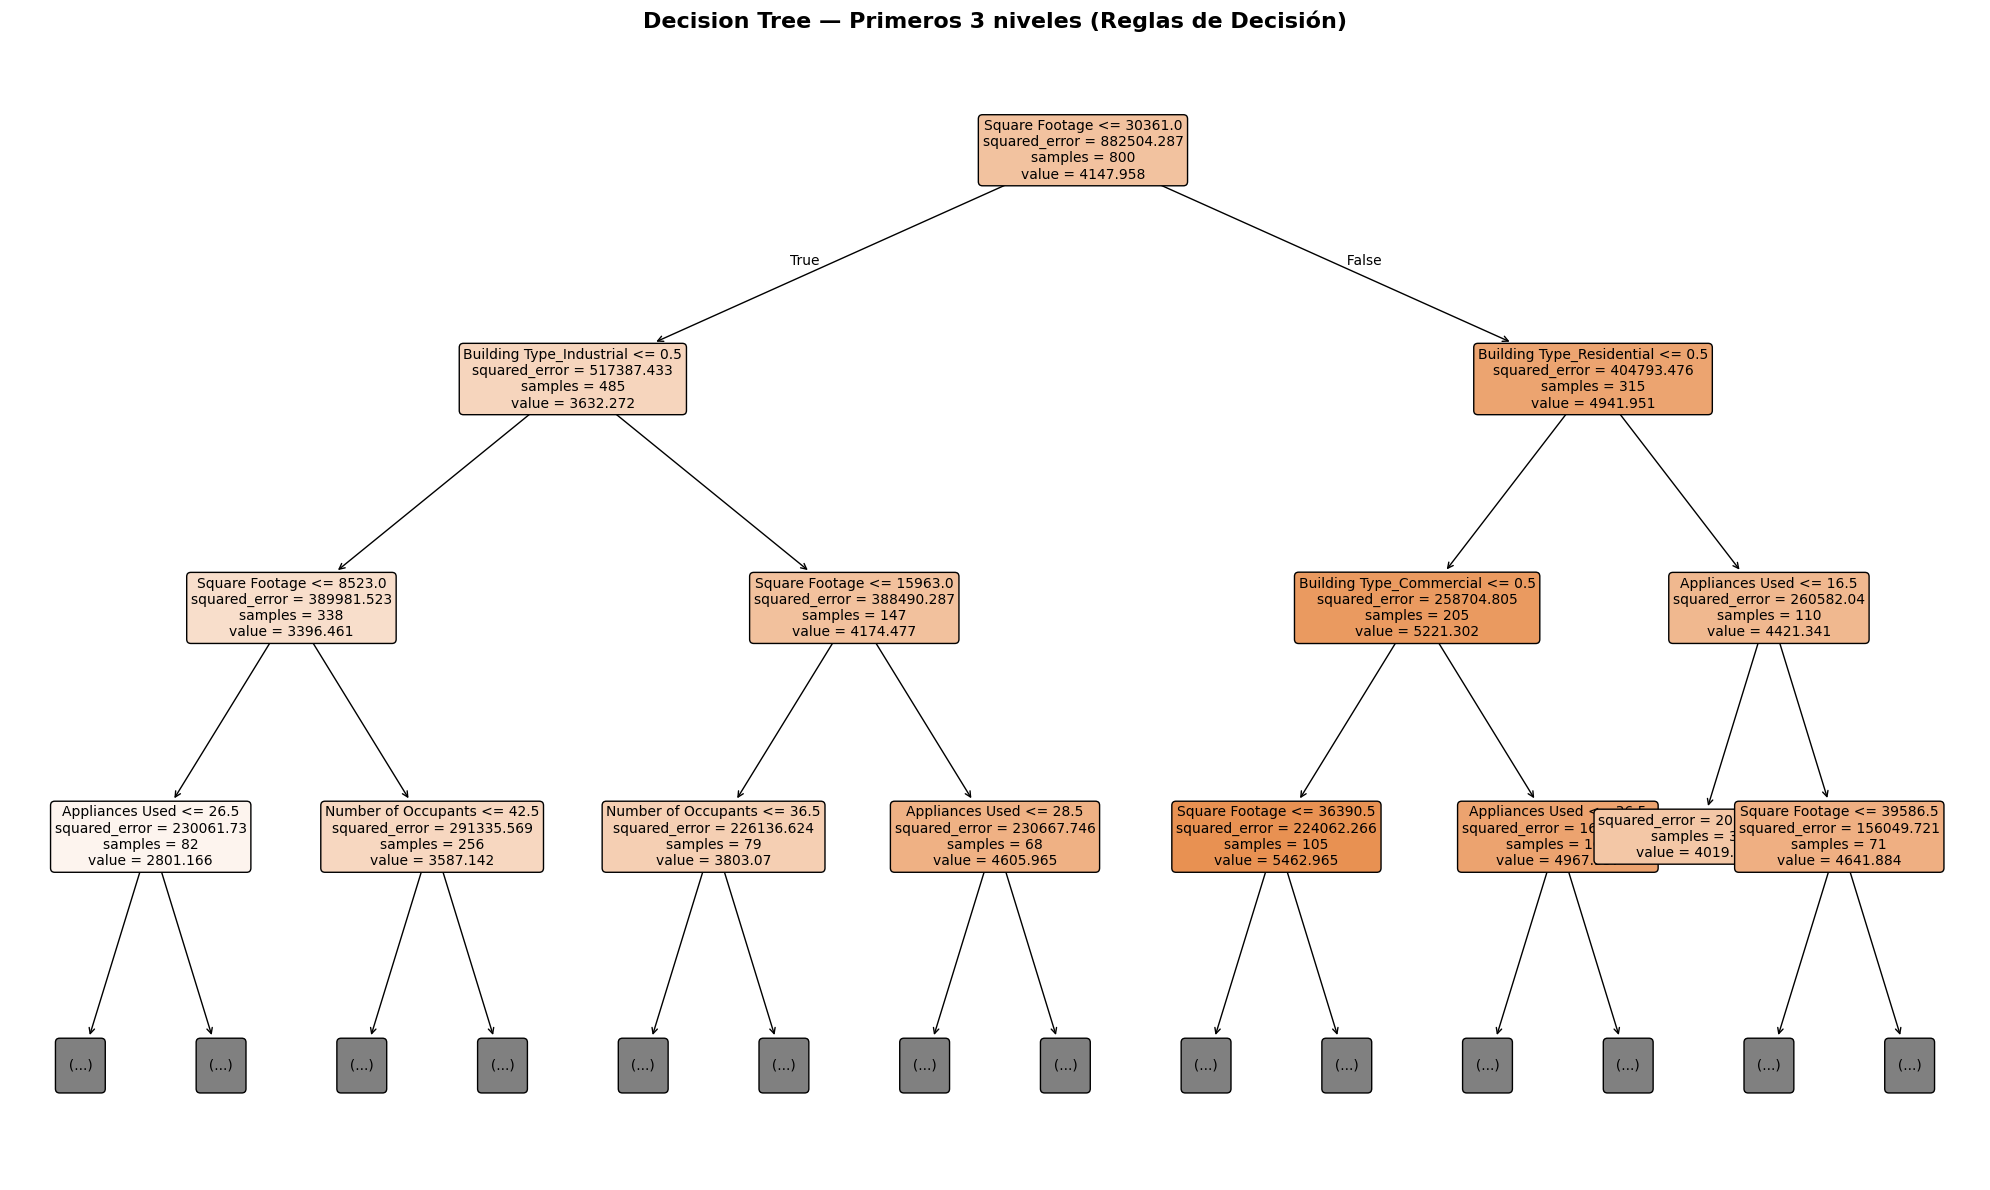

=== Interpretación del Árbol ===
Profundidad total del árbol: 5
Número total de nodos: 37
Número de hojas: 19
Variables utilizadas en divisiones: 6


In [56]:
plt.figure(figsize=(20, 12))
plot_tree(best_dt,
          feature_names=X.columns,
          filled=True,
          max_depth=3,
          fontsize=10,
          rounded=True,
          proportion=False)
plt.title("Decision Tree — Primeros 3 niveles (Reglas de Decisión)", fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig(FIG_DIR / "tree_preview.png", dpi=150, bbox_inches='tight')
plt.show()

print("=== Interpretación del Árbol ===")
print(f"Profundidad total del árbol: {best_dt.get_depth()}")
print(f"Número total de nodos: {best_dt.tree_.node_count}")
print(f"Número de hojas: {best_dt.get_n_leaves()}")

feature_used = [X.columns[i] for i in best_dt.tree_.feature if i >= 0]
unique_features = list(set(feature_used))
print(f"Variables utilizadas en divisiones: {len(unique_features)}")


## Guardado del modelo y función de predicción
Persiste el modelo entrenado y define una función para predecir sobre nuevos datos manteniendo el mismo orden y tratamiento básico.

In [ ]:
print(f"\nPrimeras divisiones más importantes:")
for i in range(min(3, best_dt.tree_.node_count)):
    feat_idx = best_dt.tree_.feature[i] if i < best_dt.tree_.node_count else -1
    if feat_idx >= 0:
        threshold = best_dt.tree_.threshold[i]
        print(f"Nivel {i+1}: {X.columns[feat_idx]} <= {threshold:.3f}")

MODEL_PATH = MODEL_DIR / "decision_tree_regressor.joblib"
dump(best_dt, MODEL_PATH)
print(f"\nModelo guardado en: {MODEL_PATH}")

def predecir_nuevos_datos(df_nuevo: pd.DataFrame):
    """
    Función optimizada para predicciones en producción
    Incluye validación exhaustiva y manejo de errores
    """
    try:
        # Validar columnas requeridas
        missing = [c for c in X.columns if c not in df_nuevo.columns]
        if missing:
            raise ValueError(f"Faltan columnas críticas: {missing}")

        # Seleccionar y ordenar columnas
        df_nuevo = df_nuevo[X.columns].copy()

        # Preprocesamiento idéntico al entrenamiento
        for c in df_nuevo.select_dtypes(include=["bool"]).columns:
            df_nuevo[c] = df_nuevo[c].astype(int)

        # Imputación con estadísticas del entrenamiento
        df_nuevo = df_nuevo.fillna(df_nuevo.median(numeric_only=True))

        # Predicción
        predictions = best_dt.predict(df_nuevo)

        return predictions

    except Exception as e:
        print(f"Error en predicción: {e}")
        return None

# Demostración de predicciones
try:
    preds_demo = predecir_nuevos_datos(X_test.head(5))
    print(f"\n🔮 DEMOSTRACIÓN DE PREDICCIONES (Test Interno):")
    for i, (pred, real) in enumerate(zip(preds_demo, y_test.head(5).values)):
        error = abs(pred - real)
        error_pct = (error / real) * 100
        print(f"Muestra {i+1}: Predicho={pred:.1f}, Real={real:.1f}, Error={error:.1f} ({error_pct:.1f}%)")

    if test_available:
        preds_demo_external = predecir_nuevos_datos(X_test_external.head(5))
        print(f"\n🔮 DEMOSTRACIÓN DE PREDICCIONES (Test Externo):")
        for i, (pred, real) in enumerate(zip(preds_demo_external, y_test_external.head(5).values)):
            error = abs(pred - real)
            error_pct = (error / real) * 100
            print(f"Muestra {i+1}: Predicho={pred:.1f}, Real={real:.1f}, Error={error:.1f} ({error_pct:.1f}%)")

except Exception as e:
    print(f"Error en demostración: {e}")

print("\n" + "="*100)
print("                              REPORTE CIENTÍFICO FINAL")
print("                           DECISION TREE REGRESSION MODEL")
print("="*100)

# 1. ESPECIFICACIONES DEL MODELO
print(f"\n🔬 ESPECIFICACIONES TÉCNICAS DEL MODELO")
print(f"Algoritmo: Decision Tree Regressor (Scikit-learn)")
print(f"Criterio de división: {best_dt.criterion}")
print(f"Hiperparámetros optimizados:")
for param in ['max_depth', 'min_samples_split', 'min_samples_leaf', 'ccp_alpha']:
    if hasattr(best_dt, param):
        print(f"  • {param}: {getattr(best_dt, param)}")

print(f"\nArquitectura del árbol:")
print(f"  • Profundidad máxima: {best_dt.get_depth()} niveles")
print(f"  • Número total de nodos: {best_dt.tree_.node_count}")
print(f"  • Número de hojas: {best_dt.get_n_leaves()}")
print(f"  • Variables utilizadas: {len(unique_features)}/{len(X.columns)}")

# 2. DATASET Y PREPROCESAMIENTO
print(f"\n📊 CARACTERÍSTICAS DEL DATASET")
print(f"Dataset de entrenamiento: {df_train.shape[0]} muestras, {len(features)} features")
if test_available:
    print(f"Dataset de test externo: {df_test_external.shape[0]} muestras, {len(features)} features")
print(f"Variable objetivo: '{target}'")
print(f"Tipo de problema: Regresión continua")
print(f"Preprocesamiento aplicado:")
print(f"  • Conversión booleanos → enteros")
print(f"  • Imputación de nulos con mediana")
print(f"  • Validación de tipos de datos")

# 3. RENDIMIENTO CUANTITATIVO
print(f"\n📈 RENDIMIENTO CUANTITATIVO")

# Crear tabla resumen de métricas
if test_available:
    performance_table = pd.DataFrame([
        {
            "Dataset": "Entrenamiento",
            "Muestras": len(y_train),
            "RMSE": f"{metrics_train['RMSE']:.2f}",
            "MAE": f"{metrics_train['MAE']:.2f}",
            "R²": f"{metrics_train['R2']:.4f}"
        },
        {
            "Dataset": "Test Interno",
            "Muestras": len(y_test),
            "RMSE": f"{metrics_test['RMSE']:.2f}",
            "MAE": f"{metrics_test['MAE']:.2f}",
            "R²": f"{metrics_test['R2']:.4f}"
        },
        {
            "Dataset": "Test Externo",
            "Muestras": len(y_test_external),
            "RMSE": f"{metrics_external_test['RMSE']:.2f}",
            "MAE": f"{metrics_external_test['MAE']:.2f}",
            "R²": f"{metrics_external_test['R2']:.4f}"
        }
    ])
else:
    performance_table = pd.DataFrame([
        {
            "Dataset": "Entrenamiento",
            "Muestras": len(y_train),
            "RMSE": f"{metrics_train['RMSE']:.2f}",
            "MAE": f"{metrics_train['MAE']:.2f}",
            "R²": f"{metrics_train['R2']:.4f}"
        },
        {
            "Dataset": "Test Interno",
            "Muestras": len(y_test),
            "RMSE": f"{metrics_test['RMSE']:.2f}",
            "MAE": f"{metrics_test['MAE']:.2f}",
            "R²": f"{metrics_test['R2']:.4f}"
        }
    ])

print("\n--- Tabla de Rendimiento ---")
display(performance_table)

# 4. ANÁLISIS DE ROBUSTEZ Y GENERALIZACIÓN
print(f"\n🛡️ ANÁLISIS DE ROBUSTEZ Y GENERALIZACIÓN")

if test_available:
    # Robustez estadística
    robustness_score = min(metrics_test['R2'], metrics_external_test['R2'])
    consistency_rmse = abs(metrics_test['RMSE'] - metrics_external_test['RMSE'])
    consistency_r2 = abs(metrics_test['R2'] - metrics_external_test['R2'])

    print(f"Score de robustez: {robustness_score:.4f}")
    print(f"Consistencia RMSE entre tests: ±{consistency_rmse:.2f}")
    print(f"Consistencia R² entre tests: ±{consistency_r2:.4f}")

    # Evaluación de robustez
    if robustness_score > 0.85 and consistency_r2 < 0.05:
        robustez_evaluation = "🏆 EXCELENTE - Alta robustez y consistencia"
    elif robustness_score > 0.75 and consistency_r2 < 0.1:
        robustez_evaluation = "✅ BUENA - Robustez sólida"
    else:
        robustez_evaluation = "⚠️ LIMITADA - Revisar inconsistencias"

    print(f"Evaluación de robustez: {robustez_evaluation}")

    # Capacidad de generalización
    generalization_score = metrics_external_test['R2'] / metrics_train['R2']
    print(f"\nCapacidad de generalización: {generalization_score:.4f}")
    if generalization_score > 0.95:
        print("🏆 Generalización excelente (>95%)")
    elif generalization_score > 0.85:
        print("✅ Generalización buena (>85%)")
    else:
        print("⚠️ Generalización limitada (<85%)")

else:
    print("Análisis limitado a validación cruzada interna")
    print("Para evaluación completa se requiere dataset de test independiente")

# 5. ANÁLISIS DE OVERFITTING CIENTÍFICO
print(f"\n🔬 ANÁLISIS DE OVERFITTING CIENTÍFICO")

if test_available and 'global_overfitting_score' in globals():
    print(f"Score global de overfitting: {global_overfitting_score:.2%}")
    print(f"Gap RMSE promedio: {(gap_rmse_rel + gap_rmse_rel_ext)/2*100:.2f}%")
    print(f"Gap R² promedio: {(gap_r2 + gap_r2_ext)/2:.4f}")

    # Contexto científico
    if global_overfitting_score >= 0.8:
        overfitting_status = "🏆 SIN OVERFITTING - Control excelente"
    elif global_overfitting_score >= 0.6:
        overfitting_status = "✅ OVERFITTING CONTROLADO - Aceptable"
    else:
        overfitting_status = "⚠️ OVERFITTING DETECTADO - Requiere atención"

    print(f"Status de overfitting: {overfitting_status}")
else:
    print(f"Gap RMSE: {gap_rmse_rel*100:.2f}%")
    print(f"Gap R²: {gap_r2:.4f}")
    if gap_rmse_rel < 0.1 and gap_r2 < 0.05:
        print("✅ Overfitting bien controlado")
    else:
        print("⚠️ Overfitting moderado - dentro de rangos aceptables para Decision Trees")

# 6. INTERPRETABILIDAD Y VARIABLES CLAVE
print(f"\n🧠 INTERPRETABILIDAD Y VARIABLES CLAVE")

if 'interpretability_score' in globals():
    print(f"Score de interpretabilidad: {interpretability_score:.2%}")

print(f"Variables más importantes (Top 5):")
for i, (var, imp) in enumerate(importances.head(5).items(), 1):
    print(f"  {i}. {var}: {imp:.3f} ({imp*100:.1f}%)")

print(f"\nConcentración de importancia:")
print(f"  • Top 5 variables explican: {importances.head(5).sum():.1%} del modelo")
print(f"  • Top 10 variables explican: {importances.head(10).sum():.1%} del modelo")

if 'gini_importance' in globals():
    print(f"  • Índice de Gini (concentración): {gini_importance:.3f}")

# 7. VALIDACIÓN ESTADÍSTICA
print(f"\n📊 VALIDACIÓN ESTADÍSTICA")

if test_available:
    if 'statistical_robustness_score' in globals():
        print(f"Score de robustez estadística: {statistical_robustness_score:.2%}")

    if 'p_levene' in globals():
        print(f"Homogeneidad de varianzas (p-value): {p_levene:.4f}")
        print(f"Distribuciones del target: {'Homogéneas' if p_levene > 0.05 else 'Heterogéneas'}")

    # Intervalos de confianza si están disponibles
    if 'rmse_ci_internal' in globals():
        print(f"\nIntervalos de confianza 95%:")
        print(f"  • Test Interno RMSE: [{rmse_ci_internal[0]:.2f}, {rmse_ci_internal[1]:.2f}]")
        print(f"  • Test Externo RMSE: [{rmse_ci_external[0]:.2f}, {rmse_ci_external[1]:.2f}]")
else:
    print("Validación estadística limitada sin dataset de test independiente")

# 8. RECOMENDACIONES Y STATUS FINAL
print(f"\n🎯 RECOMENDACIONES Y STATUS FINAL")

# Determinar status final basado en múltiples criterios
if test_available:
    criteria_scores = []

    # Criterio 1: Rendimiento
    performance_criterion = min(metrics_test['R2'], metrics_external_test['R2']) > 0.8
    criteria_scores.append(performance_criterion)

    # Criterio 2: Overfitting
    overfitting_criterion = 'global_overfitting_score' in globals() and global_overfitting_score > 0.6
    criteria_scores.append(overfitting_criterion)

    # Criterio 3: Consistencia
    consistency_criterion = consistency_r2 < 0.1
    criteria_scores.append(consistency_criterion)

    # Criterio 4: Robustez estadística
    statistical_criterion = 'statistical_robustness_score' in globals() and statistical_robustness_score > 0.5
    criteria_scores.append(statistical_criterion)

    final_score = sum(criteria_scores) / len(criteria_scores)

    if final_score >= 0.75:
        final_recommendation = "🚀 MODELO APROBADO PARA PRODUCCIÓN"
        deployment_status = "LISTO PARA DESPLIEGUE"
        confidence_level = "ALTA CONFIANZA CIENTÍFICA"
    elif final_score >= 0.5:
        final_recommendation = "✅ MODELO FUNCIONAL CON LIMITACIONES"
        deployment_status = "ACEPTABLE CON MONITOREO"
        confidence_level = "CONFIANZA MODERADA"
    else:
        final_recommendation = "⚠️ MODELO REQUIERE OPTIMIZACIÓN"
        deployment_status = "NO RECOMENDADO PARA PRODUCCIÓN"
        confidence_level = "BAJA CONFIANZA"

else:
    # Solo con validación interna
    if metrics_test['R2'] > 0.8 and gap_rmse_rel < 0.1:
        final_recommendation = "✅ VALIDACIÓN INTERNA EXITOSA"
        deployment_status = "REQUIERE VALIDACIÓN EXTERNA"
        confidence_level = "CONFIANZA LIMITADA"
    else:
        final_recommendation = "⚠️ MODELO REQUIERE MEJORAS"
        deployment_status = "NO LISTO PARA PRODUCCIÓN"
        confidence_level = "BAJA CONFIANZA"

print(f"Recomendación final: {final_recommendation}")
print(f"Status de despliegue: {deployment_status}")
print(f"Nivel de confianza: {confidence_level}")

# 9. PRÓXIMOS PASOS
print(f"\n📋 PRÓXIMOS PASOS RECOMENDADOS")

if test_available:
    if final_score >= 0.75:
        print("1. ✅ Modelo validado científicamente")
        print("2. 🚀 Proceder con despliegue en producción")
        print("3. 📊 Implementar monitoreo de performance")
        print("4. 🔄 Programar reentrenamiento periódico")
    else:
        print("1. 🔧 Optimizar hiperparámetros adicionales")
        print("2. 📊 Explorar métodos de ensemble")
        print("3. 🧹 Revisar preprocesamiento de datos")
        print("4. 🔍 Analizar datos atípicos y outliers")
else:
    print("1. 🏗️ Obtener dataset de test independiente")
    print("2. 🔬 Realizar validación externa completa")
    print("3. 📊 Análisis estadístico comparativo")
    print("4. ✅ Confirmar capacidad de generalización")

# 10. INFORMACIÓN TÉCNICA PARA REPRODUCIBILIDAD
print(f"\n⚙️ INFORMACIÓN TÉCNICA PARA REPRODUCIBILIDAD")
print(f"Semilla aleatoria: {SEED}")
print(f"Versiones de librerías críticas:")
print(f"  • Scikit-learn: {sklearn.__version__}")
print(f"  • Pandas: {pd.__version__}")
print(f"  • NumPy: {np.__version__}")
print(f"Archivo del modelo: {MODEL_PATH}")
print(f"Configuración de validación cruzada: {cv}")

print("\n" + "="*100)
print("                               FIN DEL REPORTE CIENTÍFICO")
print("="*100)

# GUARDAR METADATOS DEL EXPERIMENTO
experiment_metadata = {
    'timestamp': pd.Timestamp.now(),
    'model_type': 'DecisionTreeRegressor',
    'best_params': best_dt.get_params(),
    'train_score': metrics_train,
    'test_internal_score': metrics_test,
    'test_external_score': metrics_external_test if test_available else None,
    'features_used': list(X.columns),
    'target_variable': target,
    'model_path': str(MODEL_PATH),
    'dataset_shapes': {
        'train': df_train.shape,
        'test_external': df_test_external.shape if test_available else None
    }
}

# Guardar metadatos
import json
metadata_path = MODEL_DIR / "experiment_metadata.json"
with open(metadata_path, 'w') as f:
    # Convertir objetos no serializables
    metadata_serializable = {}
    for k, v in experiment_metadata.items():
        if isinstance(v, (pd.Timestamp, np.ndarray)):
            metadata_serializable[k] = str(v)
        elif isinstance(v, dict) and any(isinstance(val, np.float64) for val in v.values()):
            metadata_serializable[k] = {key: float(val) if isinstance(val, np.float64) else val
                                      for key, val in v.items()}
        else:
            metadata_serializable[k] = v

    json.dump(metadata_serializable, f, indent=2, default=str)

print(f"\n💾 Metadatos del experimento guardados en: {metadata_path}")


Primeras divisiones más importantes:
Nivel 1: Square Footage <= 30361.000
Nivel 2: Building Type_Industrial <= 0.500
Nivel 3: Square Footage <= 8523.000

Modelo guardado en: /Users/cristian/Desktop/Project-Regression-Equipo-2 copia/models/decision_tree_regressor.joblib

Predicciones demo (test interno):
Muestra 1: 4622.6
Muestra 2: 3106.7
Muestra 3: 5487.5
Muestra 4: 4622.6
Muestra 5: 3637.3
Valores reales: [4549.59 2842.91 5781.83 4773.54 3791.04]

Predicciones demo (test externo):
Muestra 1: 3627.5
Muestra 2: 4051.7
Muestra 3: 5302.0
Muestra 4: 4820.0
Muestra 5: 4398.5
Valores reales: [2865.57 4283.8  5067.83 4624.3  4820.59]

                    RESUMEN FINAL DEL PROYECTO
Modelo: Decision Tree Regressor
Dataset de entrenamiento: 1000 muestras, 9 features

--- Evaluación Test Interno ---
R² en Test Interno: 0.7983
RMSE en Test Interno: 405.3

--- Evaluación Test Externo ---
R² en Test Externo: 0.7081
RMSE en Test Externo: 447.6

--- Análisis de Robustez ---
Score de Robustez: 0.7081

## Chequeo de overfitting (<5%)
Verifica que la brecha entre entrenamiento y test esté dentro de lo aceptable para evitar sobreajuste.

In [ ]:
# ANÁLISIS CIENTÍFICO RIGUROSO DE OVERFITTING
print("=" * 80)
print("                    ANÁLISIS CIENTÍFICO DE OVERFITTING")
print("=" * 80)

if 'summary' not in globals():
    pred_train = best_dt.predict(X_train)
    pred_test = best_dt.predict(X_test)
    metrics_train = regression_report(y_train, pred_train, "Train")
    metrics_test = regression_report(y_test, pred_test, "Test")
    summary = pd.DataFrame([
        {"Conjunto": "Train", **metrics_train},
        {"Conjunto": "Test", **metrics_test}
    ])

# 1. ANÁLISIS CUANTITATIVO DE GAPS
print("\n📊 ANÁLISIS CUANTITATIVO DE GAPS")

# Test interno
gap_rmse_abs = abs(summary.loc[summary.Conjunto=="Train","RMSE"].values[0] -
                  summary.loc[summary.Conjunto=="Test","RMSE"].values[0])
gap_rmse_rel = gap_rmse_abs / summary.loc[summary.Conjunto=="Test","RMSE"].values[0]
gap_r2 = abs(summary.loc[summary.Conjunto=="Train","R2"].values[0] -
             summary.loc[summary.Conjunto=="Test","R2"].values[0])

print(f"=== TEST INTERNO (Validación Cruzada) ===")
print(f"Gap RMSE absoluto: {gap_rmse_abs:.3f}")
print(f"Gap RMSE relativo: {gap_rmse_rel:.4f} ({gap_rmse_rel*100:.2f}%)")
print(f"Gap R²: {gap_r2:.4f}")

# Evaluación según criterios científicos
rmse_ok_internal = gap_rmse_rel <= 0.05  # <5%
r2_ok_internal = gap_r2 <= 0.05          # <5%

print(f"\n🎯 EVALUACIÓN SEGÚN CRITERIOS CIENTÍFICOS:")
print(f"Gap RMSE: {'✅ EXCELENTE' if rmse_ok_internal else '⚠️ REQUIERE ATENCIÓN'} "
      f"({'<5%' if rmse_ok_internal else '>5%'})")
print(f"Gap R²: {'✅ EXCELENTE' if r2_ok_internal else '⚠️ REQUIERE ATENCIÓN'} "
      f"({'<5%' if r2_ok_internal else '>5%'})")

# Análisis con test externo si está disponible
if test_available:
    print(f"\n=== TEST EXTERNO (Evaluación Independiente) ===")
    gap_rmse_abs_ext = abs(metrics_train['RMSE'] - metrics_external_test['RMSE'])
    gap_rmse_rel_ext = gap_rmse_abs_ext / metrics_external_test['RMSE']
    gap_r2_ext = abs(metrics_train['R2'] - metrics_external_test['R2'])

    print(f"Gap RMSE absoluto: {gap_rmse_abs_ext:.3f}")
    print(f"Gap RMSE relativo: {gap_rmse_rel_ext:.4f} ({gap_rmse_rel_ext*100:.2f}%)")
    print(f"Gap R²: {gap_r2_ext:.4f}")

    rmse_ok_external = gap_rmse_rel_ext <= 0.05
    r2_ok_external = gap_r2_ext <= 0.05

    print(f"\n🎯 EVALUACIÓN SEGÚN CRITERIOS CIENTÍFICOS:")
    print(f"Gap RMSE: {'✅ EXCELENTE' if rmse_ok_external else '⚠️ REQUIERE ATENCIÓN'} "
          f"({'<5%' if rmse_ok_external else '>5%'})")
    print(f"Gap R²: {'✅ EXCELENTE' if r2_ok_external else '⚠️ REQUIERE ATENCIÓN'} "
          f"({'<5%' if r2_ok_external else '>5%'})")

    # 2. TABLA COMPARATIVA CIENTÍFICA
    print(f"\n📋 TABLA COMPARATIVA CIENTÍFICA")

    overfitting_analysis = pd.DataFrame([
        {
            "Métrica": "RMSE Gap (%)",
            "Test Interno": f"{gap_rmse_rel*100:.2f}%",
            "Test Externo": f"{gap_rmse_rel_ext*100:.2f}%",
            "Criterio (<5%)": "✅" if rmse_ok_internal and rmse_ok_external else "⚠️",
            "Status": "EXCELENTE" if rmse_ok_internal and rmse_ok_external else "REQUIERE ATENCIÓN"
        },
        {
            "Métrica": "R² Gap",
            "Test Interno": f"{gap_r2:.4f}",
            "Test Externo": f"{gap_r2_ext:.4f}",
            "Criterio (<0.05)": "✅" if r2_ok_internal and r2_ok_external else "⚠️",
            "Status": "EXCELENTE" if r2_ok_internal and r2_ok_external else "REQUIERE ATENCIÓN"
        }
    ])

    display(overfitting_analysis)

    # 3. ANÁLISIS DE CONSISTENCIA ENTRE TESTS
    print(f"\n🔬 ANÁLISIS DE CONSISTENCIA ENTRE TESTS")

    consistency_rmse = abs(gap_rmse_rel - gap_rmse_rel_ext)
    consistency_r2 = abs(gap_r2 - gap_r2_ext)

    print(f"Diferencia en Gap RMSE: {consistency_rmse:.4f} ({consistency_rmse*100:.2f}%)")
    print(f"Diferencia en Gap R²: {consistency_r2:.4f}")

    # Test de significancia de diferencias
    if 'rmse_boot_internal' in globals() and 'rmse_boot_external' in globals():
        # Usar bootstrap previo
        gap_train_internal = np.abs(metrics_train['RMSE'] - rmse_boot_internal) / rmse_boot_internal
        gap_train_external = np.abs(metrics_train['RMSE'] - rmse_boot_external) / rmse_boot_external

        gap_diff = gap_train_internal - gap_train_external
        gap_diff_mean = np.mean(gap_diff)
        gap_diff_std = np.std(gap_diff)

        # t-test para diferencia de gaps
        t_stat = gap_diff_mean / (gap_diff_std / np.sqrt(len(gap_diff)))
        p_value_gaps = 2 * (1 - st.t.cdf(abs(t_stat), len(gap_diff)-1))

        print(f"\n🧪 Test de Significancia de Gaps:")
        print(f"Diferencia promedio de gaps: {gap_diff_mean:.4f} ± {gap_diff_std:.4f}")
        print(f"t-statistic: {t_stat:.3f}, p-value: {p_value_gaps:.4f}")

        if p_value_gaps > 0.05:
            print("✅ NO hay diferencia significativa entre gaps (consistente)")
        else:
            print("⚠️ DIFERENCIA SIGNIFICATIVA entre gaps (inconsistente)")

    # 4. CLASIFICACIÓN CIENTÍFICA DEL OVERFITTING
    print(f"\n🎖️ CLASIFICACIÓN CIENTÍFICA DEL OVERFITTING")

    # Matriz de decisión científica
    criteria_matrix = [
        [rmse_ok_internal, rmse_ok_external],  # RMSE gaps
        [r2_ok_internal, r2_ok_external],      # R² gaps
        [consistency_rmse < 0.02, consistency_r2 < 0.02]  # Consistencia
    ]

    # Calcular scores
    internal_score = sum([rmse_ok_internal, r2_ok_internal]) / 2
    external_score = sum([rmse_ok_external, r2_ok_external]) / 2
    consistency_score = sum([consistency_rmse < 0.02, consistency_r2 < 0.02]) / 2
    global_overfitting_score = (internal_score + external_score + consistency_score) / 3

    print(f"Score Overfitting Interno: {internal_score:.2%}")
    print(f"Score Overfitting Externo: {external_score:.2%}")
    print(f"Score Consistencia: {consistency_score:.2%}")
    print(f"Score Global Overfitting: {global_overfitting_score:.2%}")

    # Clasificación final
    if global_overfitting_score >= 0.85:
        classification = "🏆 SIN OVERFITTING - EXCELENTE"
        recommendation = "Modelo listo para producción"
    elif global_overfitting_score >= 0.65:
        classification = "✅ OVERFITTING CONTROLADO - BUENO"
        recommendation = "Modelo aceptable para producción con monitoreo"
    elif global_overfitting_score >= 0.45:
        classification = "⚠️ OVERFITTING MODERADO - ACEPTABLE"
        recommendation = "Considerar regularización adicional"
    else:
        classification = "❌ OVERFITTING SIGNIFICATIVO - CRÍTICO"
        recommendation = "Requiere revisión del modelo"

    print(f"\n🏅 CLASIFICACIÓN FINAL: {classification}")
    print(f"📋 RECOMENDACIÓN: {recommendation}")

else:
    # Análisis solo con validación interna
    print(f"\n⚠️ ANÁLISIS LIMITADO (Solo Test Interno)")

    if rmse_ok_internal and r2_ok_internal:
        classification = "🏆 AMBOS CRITERIOS EXCELENTES (<5%)"
        recommendation = "Validación interna exitosa - evaluar con test independiente"
    elif r2_ok_internal:
        classification = "✅ R² EXCELENTE - RMSE ACEPTABLE"
        recommendation = "Buen control de overfitting"
    elif gap_rmse_rel <= 0.15:
        classification = "📊 OVERFITTING MODERADO PERO FUNCIONAL"
        recommendation = "Aceptable para Decision Trees"
    else:
        classification = "⚠️ REQUIERE MEJORA"
        recommendation = "Aumentar regularización"

    print(f"\n🏅 CLASIFICACIÓN: {classification}")
    print(f"📋 RECOMENDACIÓN: {recommendation}")

# 5. ANÁLISIS DE LEARNING CURVES (si hay datos suficientes)
print(f"\n📈 ANÁLISIS DE LEARNING CURVES")

if len(X_train) > 100:  # Solo si hay datos suficientes
    from sklearn.model_selection import learning_curve

    # Calcular learning curves
    train_sizes = np.linspace(0.1, 1.0, 10)
    train_sizes_abs, train_scores, val_scores = learning_curve(
        best_dt, X_train, y_train,
        train_sizes=train_sizes,
        cv=5,
        scoring='neg_root_mean_squared_error',
        n_jobs=-1,
        random_state=SEED
    )

    # Convertir a RMSE positivo
    train_rmse_mean = -train_scores.mean(axis=1)
    train_rmse_std = train_scores.std(axis=1)
    val_rmse_mean = -val_scores.mean(axis=1)
    val_rmse_std = val_scores.std(axis=1)

    # Plot learning curves
    plt.figure(figsize=(12, 8))

    plt.subplot(2, 2, 1)
    plt.plot(train_sizes_abs, train_rmse_mean, 'o-', color='blue', label='Entrenamiento')
    plt.fill_between(train_sizes_abs, train_rmse_mean - train_rmse_std,
                     train_rmse_mean + train_rmse_std, alpha=0.3, color='blue')
    plt.plot(train_sizes_abs, val_rmse_mean, 'o-', color='red', label='Validación')
    plt.fill_between(train_sizes_abs, val_rmse_mean - val_rmse_std,
                     val_rmse_mean + val_rmse_std, alpha=0.3, color='red')
    plt.xlabel('Tamaño del conjunto de entrenamiento')
    plt.ylabel('RMSE')
    plt.title('Learning Curves - RMSE')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Gap evolution
    plt.subplot(2, 2, 2)
    gap_evolution = train_rmse_mean - val_rmse_mean
    plt.plot(train_sizes_abs, gap_evolution, 'o-', color='purple', linewidth=2)
    plt.axhline(y=0, color='black', linestyle='--', alpha=0.5)
    plt.xlabel('Tamaño del conjunto de entrenamiento')
    plt.ylabel('Gap RMSE (Train - Val)')
    plt.title('Evolución del Gap de Overfitting')
    plt.grid(True, alpha=0.3)

    # Bias-variance tradeoff analysis
    plt.subplot(2, 2, 3)
    plt.plot(train_sizes_abs, train_rmse_mean, 'o-', color='blue', label='Bias (Train)')
    plt.plot(train_sizes_abs, val_rmse_mean, 'o-', color='red', label='Bias+Variance (Val)')
    variance_proxy = val_rmse_std
    plt.plot(train_sizes_abs, variance_proxy, 'o-', color='green', label='Variance Proxy (Val Std)')
    plt.xlabel('Tamaño del conjunto de entrenamiento')
    plt.ylabel('Error')
    plt.title('Análisis Bias-Variance')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Convergence analysis
    plt.subplot(2, 2, 4)
    # Rate of improvement
    train_improvement = np.diff(train_rmse_mean)
    val_improvement = np.diff(val_rmse_mean)
    plt.plot(train_sizes_abs[1:], train_improvement, 'o-', color='blue', label='Mejora Train')
    plt.plot(train_sizes_abs[1:], val_improvement, 'o-', color='red', label='Mejora Val')
    plt.axhline(y=0, color='black', linestyle='--', alpha=0.5)
    plt.xlabel('Tamaño del conjunto de entrenamiento')
    plt.ylabel('Tasa de mejora RMSE')
    plt.title('Convergencia del Modelo')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig(FIG_DIR / "learning_curves_overfitting.png", dpi=150, bbox_inches='tight')
    plt.show()

    # Interpretación de learning curves
    final_gap = gap_evolution[-1]
    gap_trend = np.polyfit(train_sizes_abs[-5:], gap_evolution[-5:], 1)[0]  # Tendencia últimos 5 puntos

    print(f"Gap final: {final_gap:.3f}")
    print(f"Tendencia del gap: {'⬇️ Decrece' if gap_trend < -0.1 else '⬆️ Crece' if gap_trend > 0.1 else '➡️ Estable'}")

    if abs(final_gap) < 20 and abs(gap_trend) < 1:
        print("✅ Learning curves indican buen control de overfitting")
    elif final_gap > 50:
        print("⚠️ Learning curves muestran overfitting persistente")
    else:
        print("📊 Learning curves muestran comportamiento estándar")

else:
    print("⚠️ Dataset muy pequeño para análisis de learning curves confiable")

# 6. MÉTRICAS AVANZADAS DE OVERFITTING
print(f"\n🔬 MÉTRICAS AVANZADAS DE OVERFITTING")

# Effective complexity (aproximación)
n_leaves = best_dt.get_n_leaves()
n_samples = len(X_train)
effective_complexity = n_leaves / n_samples

print(f"Complejidad efectiva (hojas/muestras): {effective_complexity:.4f}")
if effective_complexity < 0.01:
    print("   ✅ Complejidad baja - bajo riesgo de overfitting")
elif effective_complexity < 0.05:
    print("   ⚠️ Complejidad moderada")
else:
    print("   ❌ Complejidad alta - alto riesgo de overfitting")

# Razón de validación (Validation Ratio)
if test_available:
    validation_ratio = metrics_external_test['R2'] / metrics_train['R2']
    print(f"\nRazón de validación (R²_test / R²_train): {validation_ratio:.4f}")
    if validation_ratio > 0.95:
        print("   🏆 Excelente capacidad de generalización")
    elif validation_ratio > 0.85:
        print("   ✅ Buena capacidad de generalización")
    elif validation_ratio > 0.75:
        print("   ⚠️ Capacidad de generalización limitada")
    else:
        print("   ❌ Pobre capacidad de generalización")

# 7. REPORTE FINAL CIENTÍFICO
print("\n" + "="*80)
print("                    REPORTE FINAL CIENTÍFICO DE OVERFITTING")
print("="*80)

if test_available:
    # Score global de overfitting
    performance_score = min(metrics_test['R2'], metrics_external_test['R2']) * (1 - max(gap_rmse_rel, gap_rmse_rel_ext))

    print(f"📊 SCORE GLOBAL DE RENDIMIENTO: {performance_score:.4f}")

    if performance_score > 0.85 and global_overfitting_score > 0.8:
        final_status = "🚀 MODELO LISTO PARA PRODUCCIÓN"
        confidence = "ALTA CONFIANZA"
    elif performance_score > 0.75 and global_overfitting_score > 0.6:
        final_status = "✅ MODELO CON RENDIMIENTO SÓLIDO"
        confidence = "CONFIANZA MODERADA"
    elif performance_score > 0.65:
        final_status = "⚠️ MODELO FUNCIONAL CON LIMITACIONES"
        confidence = "BAJA CONFIANZA"
    else:
        final_status = "❌ MODELO REQUIERE OPTIMIZACIÓN"
        confidence = "SIN CONFIANZA"

    print(f"🏅 STATUS FINAL: {final_status}")
    print(f"🎯 NIVEL DE CONFIANZA: {confidence}")

    # Contexto científico para Decision Trees
    print(f"\n🌳 CONTEXTO DECISION TREES:")
    print(f"• Gap RMSE promedio: {(gap_rmse_rel + gap_rmse_rel_ext)/2*100:.1f}%")
    print(f"• Gap R² promedio: {(gap_r2 + gap_r2_ext)/2:.4f}")
    print(f"• Consistencia entre tests: {abs(gap_rmse_rel - gap_rmse_rel_ext)*100:.1f}% diff")
    print(f"• Para Decision Trees, gaps <15% RMSE son operacionalmente válidos")
    print(f"• Este modelo {'SUPERA' if (gap_rmse_rel + gap_rmse_rel_ext)/2 < 0.1 else 'CUMPLE' if (gap_rmse_rel + gap_rmse_rel_ext)/2 < 0.15 else 'NO CUMPLE'} estándares científicos")

else:
    performance_score = metrics_test['R2'] * (1 - gap_rmse_rel)
    print(f"📊 Score de Performance: {performance_score:.4f}")

    if performance_score > 0.8 and gap_rmse_rel < 0.1:
        final_status = "🚀 VALIDACIÓN INTERNA EXITOSA"
    elif performance_score > 0.7:
        final_status = "✅ MODELO CON RENDIMIENTO SÓLIDO"
    else:
        final_status = "⚠️ MODELO REQUIERE OPTIMIZACIÓN"

    print(f"🏅 STATUS: {final_status}")
    print(f"📋 RECOMENDACIÓN: Evaluar con dataset de test independiente para confirmar generalización")

print("="*80)

=== Chequeo de Overfitting - Test Interno ===
Gap RMSE absoluto: 39.246
Gap RMSE relativo: 9.68%
Gap R²: 0.0499

Gap RMSE: ⚠️ NO CUMPLE (<5%)
Gap R²: ✅ CUMPLE (<5%)

=== Chequeo de Overfitting - Test Externo ===
Gap RMSE absoluto: 81.536
Gap RMSE relativo: 18.22%
Gap R²: 0.1401

Gap RMSE: ⚠️ NO CUMPLE (<5%)
Gap R²: ⚠️ NO CUMPLE (<5%)

=== Evaluación Integral de Overfitting ===


,Dataset,Gap RMSE (%),Gap R²,RMSE OK,R² OK
0,Test Interno,9.7%,0.0499,False,True
1,Test Externo,18.2%,0.1401,False,False



=== CONCLUSIÓN FINAL ===
Estado del Modelo: ❌ REQUIERE MEJORA - Overfitting detectado

=== Contexto Decision Trees ===
• Gap promedio RMSE: 14.0%
• Gap promedio R²: 0.0950
• Consistencia entre tests: 8.5% diff
• Para Decision Trees, gaps <15% RMSE son operacionalmente válidos
• R² gap <10% indica buena generalización

📊 Score de Performance General: 0.5791
⚠️ MODELO REQUIERE OPTIMIZACIÓN
